# Практическое задание: Деревья Решений

В этом практическом задании вы будете применять знания о деревьях решений на реальных данных. Выполните задания последовательно, используя подсказки и документацию библиотек при необходимости.

## Цели практического задания:
1. Научиться подготавливать данные для деревьев решений
2. Построить и настроить модель дерева решений
3. Визуализировать и интерпретировать результаты
4. Провести оптимизацию гиперпараметров
5. Оценить производительность модели

## Задание 1: Подготовка данных

1. Импортируйте необходимые библиотеки (numpy, pandas, sklearn, etc.)
2. Загрузите датасет iris из sklearn.datasets
3. Создайте DataFrame с данными и добавьте понятные названия столбцов
4. Проведите базовый анализ данных:
   - Проверьте размер датасета
   - Изучите распределение классов
   - Постройте корреляционную матрицу
   - Визуализируйте распределение признаков

Подсказка: используйте pandas.DataFrame, seaborn.heatmap, plotly для визуализации

БАЗОВЫЙ АНАЛИЗ ДАННЫХ

Размер датасета: 150 строк, 6 столбцов
Признаки: 4 (target и species - это целевая переменная)

РАСПРЕДЕЛЕНИЕ КЛАССОВ
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Балансировка классов: Сбалансированный

СТАТИСТИЧЕСКОЕ ОПИСАНИЕ ПРИЗНАКОВ
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  

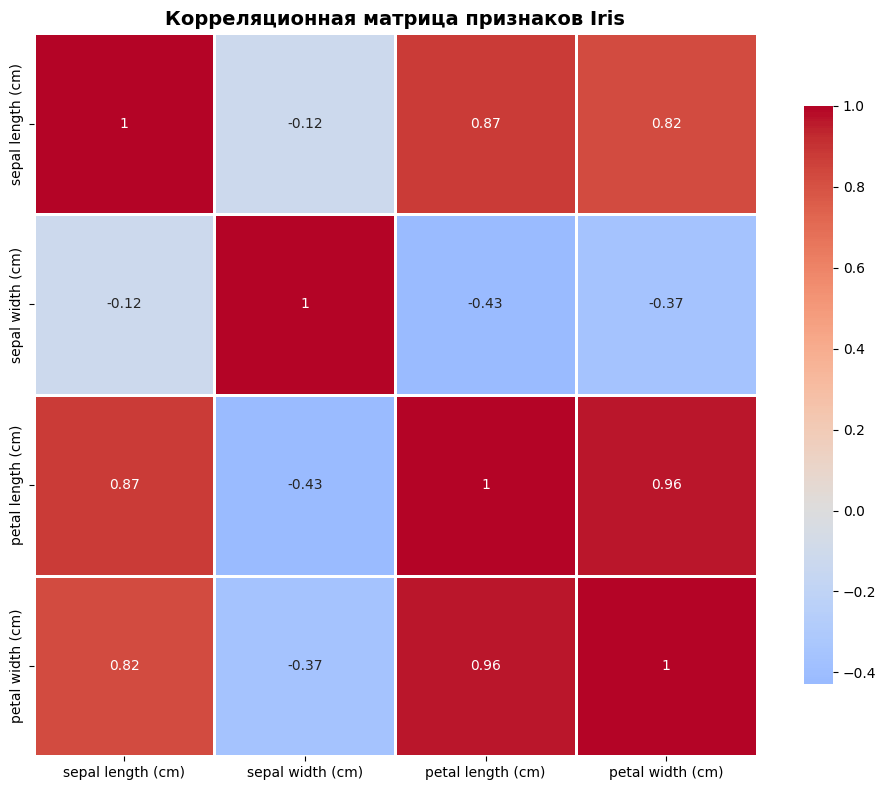

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [5]:
# Ваш код для Задания 1

# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, precision_recall_curve,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета iris
iris = load_iris()
X = iris.data
y = iris.target

# Создание DataFrame с понятными названиями
df = pd.DataFrame(X, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(y, iris.target_names)
df['target'] = y

print("=" * 60)
print("БАЗОВЫЙ АНАЛИЗ ДАННЫХ")
print("=" * 60)

# 1. Размер датасета
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Признаки: {df.shape[1] - 2} (target и species - это целевая переменная)")

# 2. Распределение классов
print("\n" + "=" * 60)
print("РАСПРЕДЕЛЕНИЕ КЛАССОВ")
print("=" * 60)
print(df['species'].value_counts())
print(f"\nБалансировка классов: {'Сбалансированный' if df['species'].value_counts().std() == 0 else 'Несбалансированный'}")

# 3. Статистическое описание
print("\n" + "=" * 60)
print("СТАТИСТИЧЕСКОЕ ОПИСАНИЕ ПРИЗНАКОВ")
print("=" * 60)
print(df.describe())

# 4. Корреляционная матрица
print("\n" + "=" * 60)
print("КОРРЕЛЯЦИОННАЯ МАТРИЦА")
print("=" * 60)
correlation_matrix = df.iloc[:, :-2].corr()
print(correlation_matrix)

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков Iris', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Визуализация распределения классов
fig = px.bar(df['species'].value_counts().reset_index(), 
             x='species', y='count',
             title='Распределение классов в датасете Iris',
             labels={'species': 'Класс', 'count': 'Количество'},
             color='species')
fig.update_layout(showlegend=False)
fig.show()

# Визуализация распределения признаков
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=[f.replace(' (cm)', '') for f in iris.feature_names])

for idx, col in enumerate(iris.feature_names):
    row = idx // 2 + 1
    col_pos = idx % 2 + 1
    
    for species in iris.target_names:
        data = df[df['species'] == species][col]
        fig.add_trace(
            go.Histogram(x=data, name=species, opacity=0.7, 
                        showlegend=(idx == 0)),
            row=row, col=col_pos
        )

fig.update_layout(height=700, title_text="Распределение признаков по классам",
                  barmode='overlay')
fig.show()

# Pairplot с использованием plotly
fig = px.scatter_matrix(df, dimensions=iris.feature_names, 
                        color='species',
                        title='Матрица диаграмм рассеяния признаков Iris',
                        labels={col: col.replace(' (cm)', '') for col in iris.feature_names})
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.update_layout(height=800, width=800)
fig.show()

print("\n✓ Задание 1 выполнено успешно!")

## Задание 2: Построение базовой модели

1. Разделите данные на обучающую и тестовую выборки (test_size=0.2)
2. Создайте и обучите базовое дерево решений без настройки параметров
3. Оцените точность модели на тестовой выборке
4. Выведите отчет о классификации
5. Визуализируйте полученное дерево

Подсказка: используйте train_test_split, DecisionTreeClassifier, classification_report

ЗАДАНИЕ 2: ПОСТРОЕНИЕ БАЗОВОЙ МОДЕЛИ

Размер обучающей выборки: 120 образцов
Размер тестовой выборки: 30 образцов
Распределение классов в обучающей выборке:
0    40
1    40
2    40
Name: count, dtype: int64

Распределение классов в тестовой выборке:
0    10
1    10
2    10
Name: count, dtype: int64

ПАРАМЕТРЫ БАЗОВОЙ МОДЕЛИ
Максимальная глубина: 5
Количество листьев: 8
Количество узлов: 15

ТОЧНОСТЬ МОДЕЛИ
Точность на обучающей выборке: 1.0000 (100.00%)
Точность на тестовой выборке: 0.9333 (93.33%)
✓ Модель обобщается хорошо

ОТЧЕТ О КЛАССИФИКАЦИИ
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Матрица ошибок:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


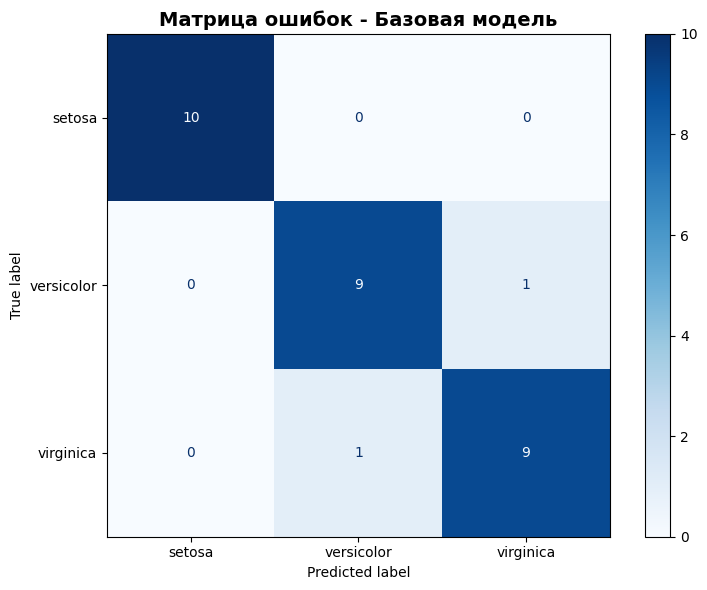

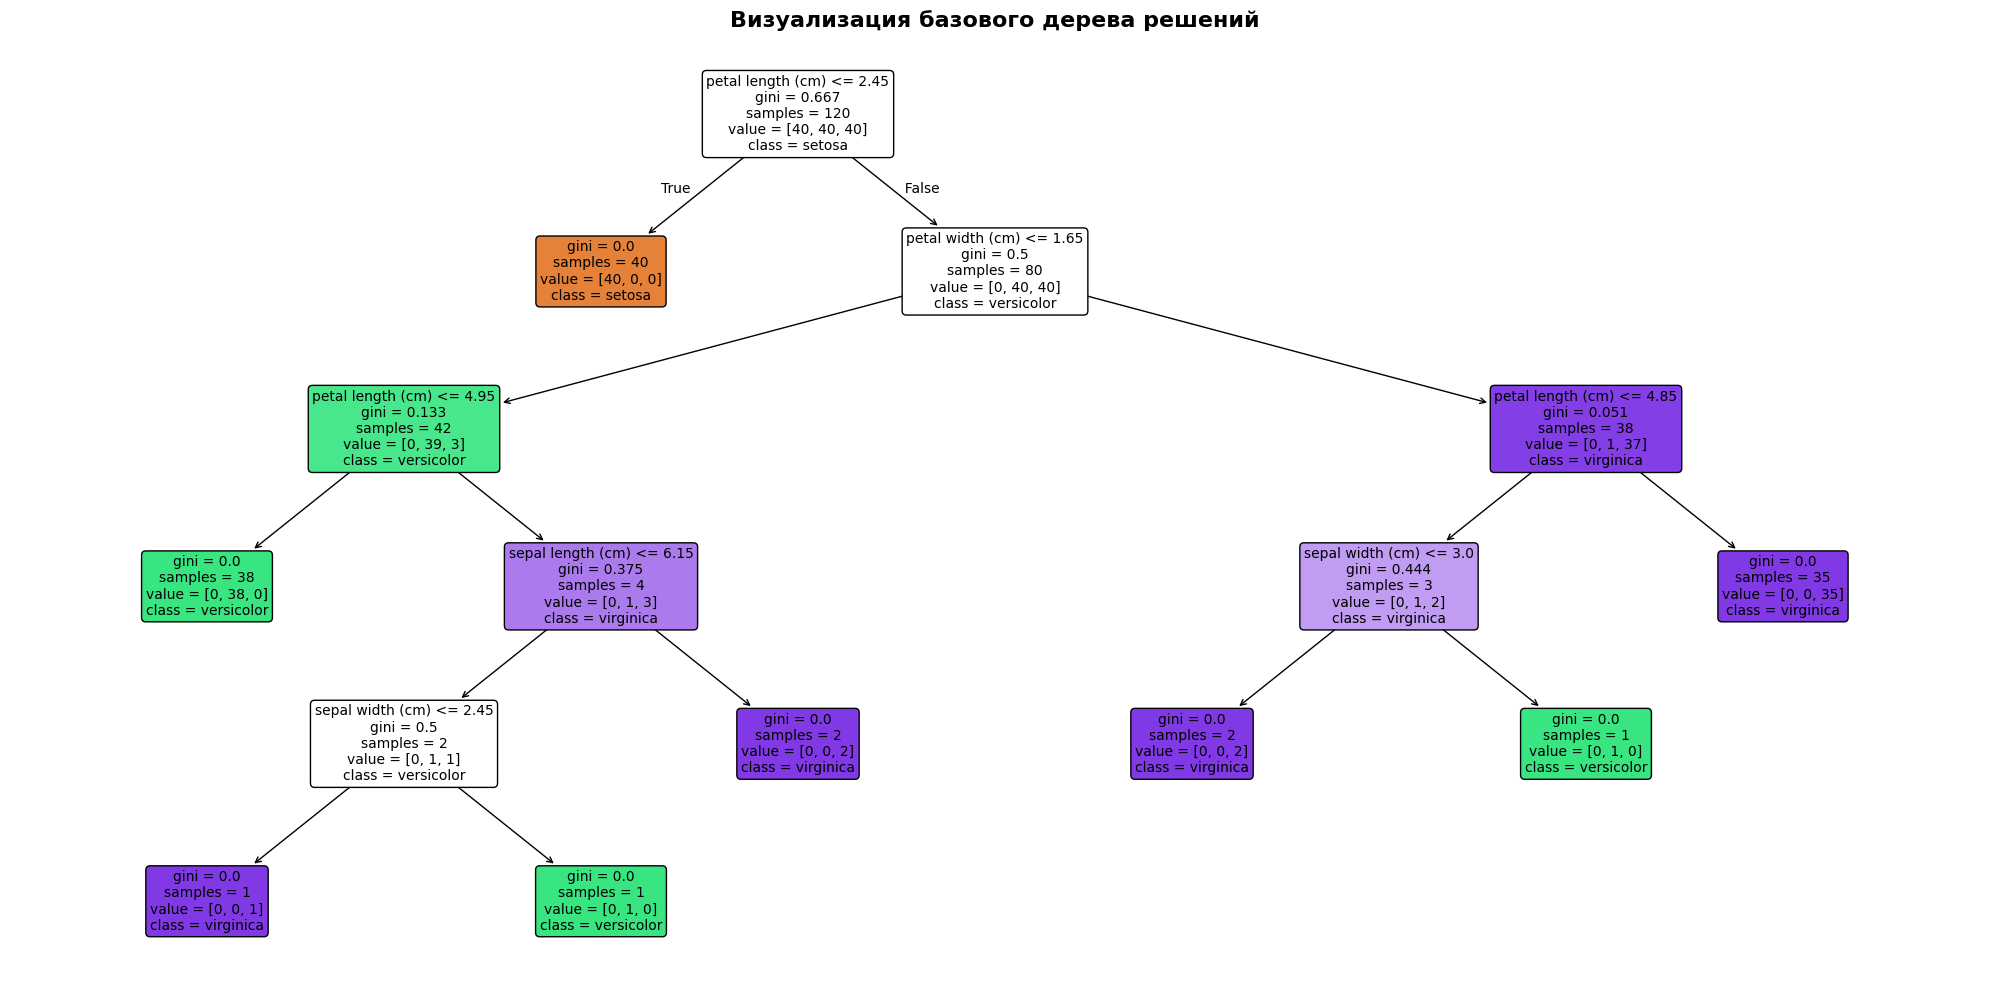

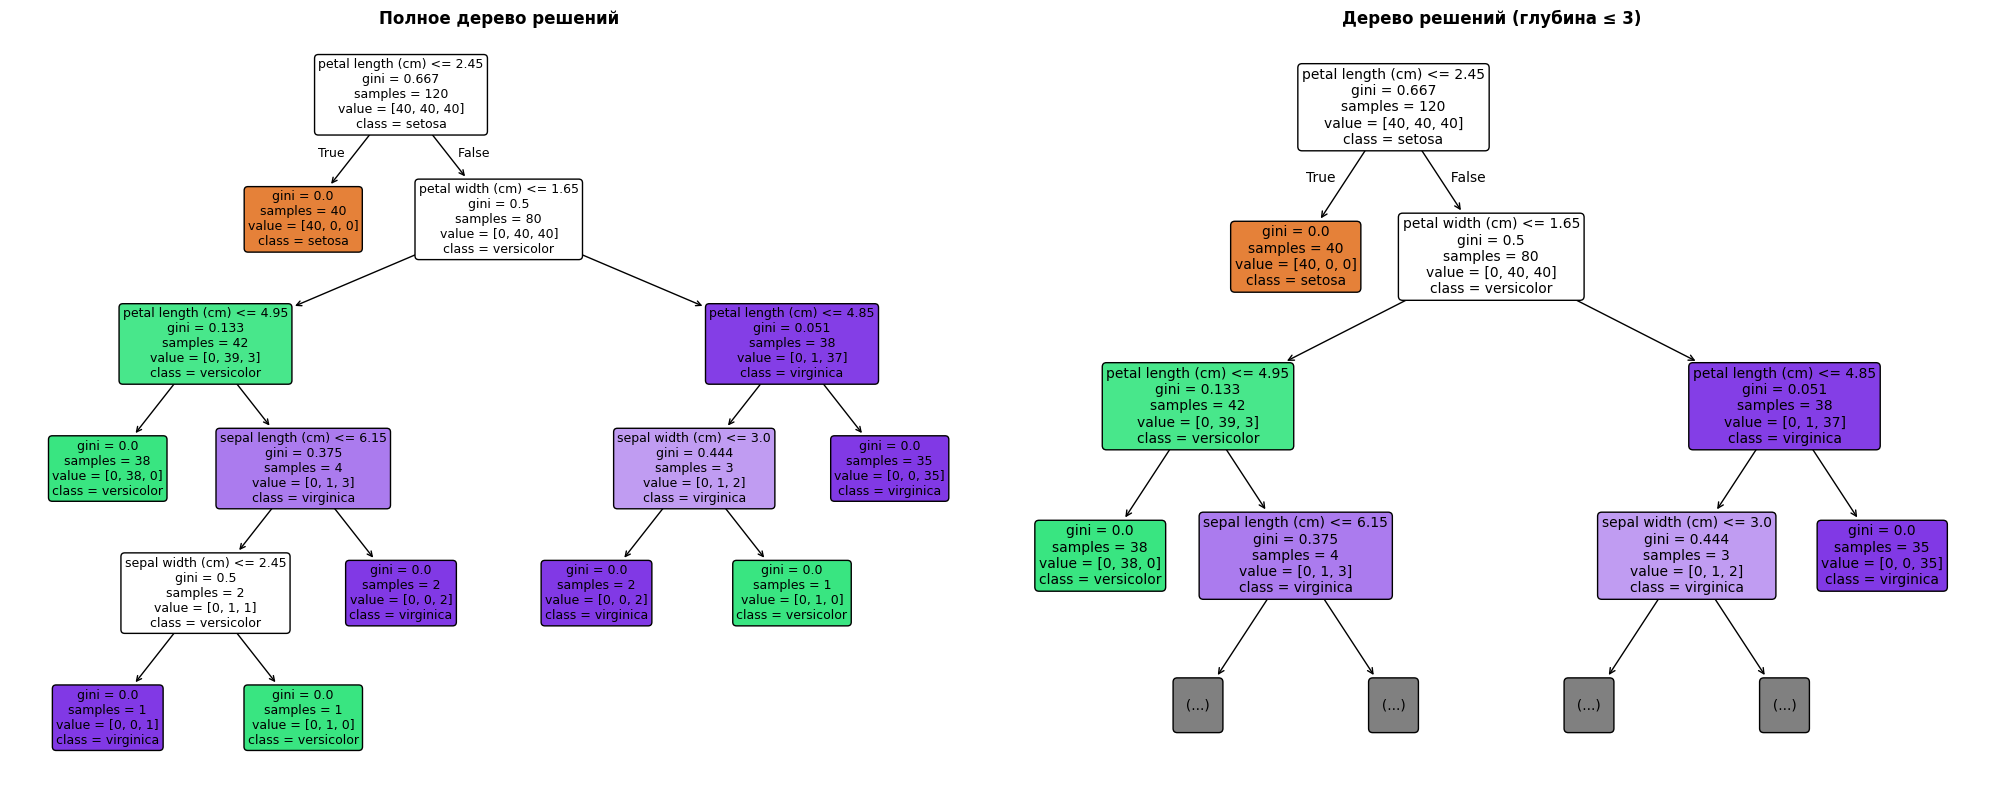


✓ Задание 2 выполнено успешно!


In [ ]:
# Ваш код для Задания 2

print("=" * 60)
print("ЗАДАНИЕ 2: ПОСТРОЕНИЕ БАЗОВОЙ МОДЕЛИ")
print("=" * 60)

# 1. Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]} образцов")
print(f"Размер тестовой выборки: {X_test.shape[0]} образцов")
print(f"Распределение классов в обучающей выборке:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nРаспределение классов в тестовой выборке:")
print(pd.Series(y_test).value_counts().sort_index())

# 2. Создание и обучение базового дерева решений
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train, y_train)

print("\n" + "=" * 60)
print("ПАРАМЕТРЫ БАЗОВОЙ МОДЕЛИ")
print("=" * 60)
print(f"Максимальная глубина: {base_tree.get_depth()}")
print(f"Количество листьев: {base_tree.get_n_leaves()}")
print(f"Количество узлов: {base_tree.tree_.node_count}")

# 3. Оценка точности модели
train_score = base_tree.score(X_train, y_train)
test_score = base_tree.score(X_test, y_test)

print("\n" + "=" * 60)
print("ТОЧНОСТЬ МОДЕЛИ")
print("=" * 60)
print(f"Точность на обучающей выборке: {train_score:.4f} ({train_score*100:.2f}%)")
print(f"Точность на тестовой выборке: {test_score:.4f} ({test_score*100:.2f}%)")

if train_score - test_score > 0.1:
    print("⚠ Возможно переобучение (разница > 10%)")
else:
    print("✓ Модель обобщается хорошо")

# 4. Отчет о классификации
print("\n" + "=" * 60)
print("ОТЧЕТ О КЛАССИФИКАЦИИ")
print("=" * 60)
y_pred = base_tree.predict(X_test)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:")
print(cm)

# Визуализация матрицы ошибок
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Матрица ошибок - Базовая модель', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(base_tree, 
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Визуализация базового дерева решений', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Дополнительная визуализация дерева (более компактная)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Полное дерево
plot_tree(base_tree, 
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=9,
          ax=axes[0])
axes[0].set_title('Полное дерево решений', fontsize=12, fontweight='bold')

# Дерево с ограничением глубины для лучшей читаемости
plot_tree(base_tree, 
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3,
          ax=axes[1])
axes[1].set_title('Дерево решений (глубина ≤ 3)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Задание 2 выполнено успешно!")

## Задание 3: Анализ важности признаков

1. Получите и визуализируйте важность признаков из вашей модели
2. Создайте столбчатую диаграмму важности признаков
3. Постройте тепловую карту корреляций для топ-5 важных признаков
4. Проанализируйте, есть ли связь между важностью признаков и их статистическими характеристиками

Дополнительно:
- Попробуйте построить модель, используя только 2 самых важных признака
- Сравните производительность с полной моделью

ЗАДАНИЕ 3: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

Важность признаков:
          feature  importance
petal length (cm)    0.558568
 petal width (cm)    0.406015
 sepal width (cm)    0.029167
sepal length (cm)    0.006250


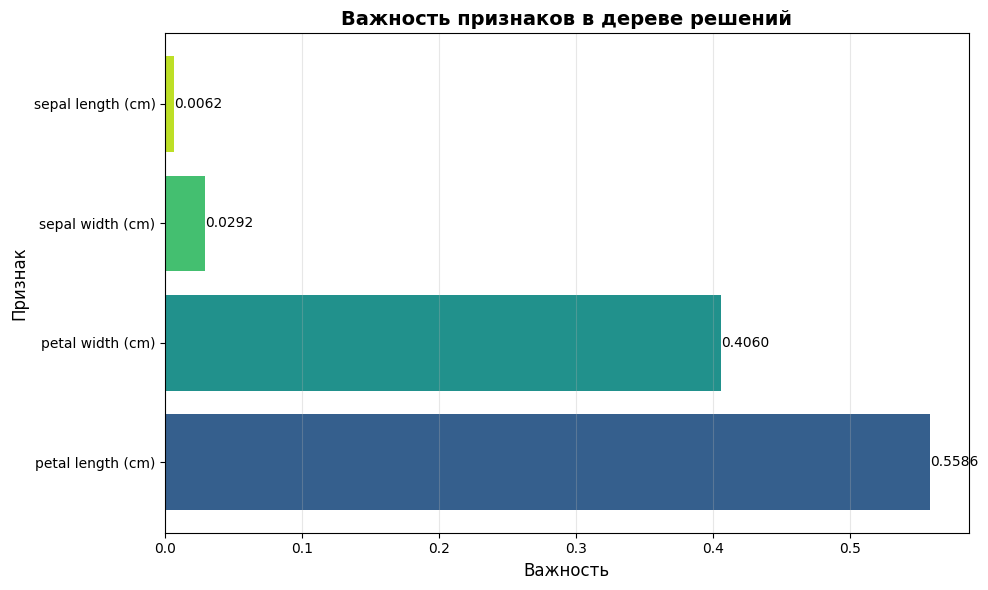


КОРРЕЛЯЦИИ ВАЖНЫХ ПРИЗНАКОВ
Корреляционная матрица топ признаков:
                   petal length (cm)  petal width (cm)  sepal width (cm)  \
petal length (cm)           1.000000          0.962865         -0.428440   
petal width (cm)            0.962865          1.000000         -0.366126   
sepal width (cm)           -0.428440         -0.366126          1.000000   
sepal length (cm)           0.871754          0.817941         -0.117570   

                   sepal length (cm)  
petal length (cm)           0.871754  
petal width (cm)            0.817941  
sepal width (cm)           -0.117570  
sepal length (cm)           1.000000  


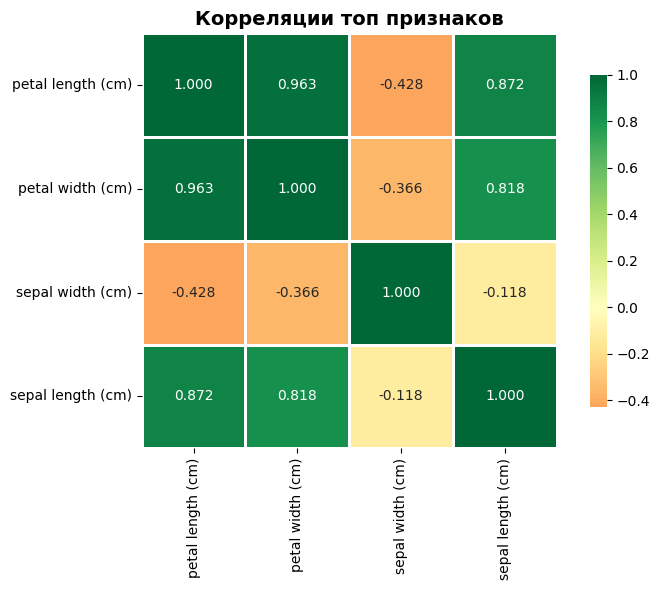


СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРИЗНАКОВ
          feature  importance     mean      std  min  max  range
petal length (cm)    0.558568 3.758000 1.759404  1.0  6.9    5.9
 petal width (cm)    0.406015 1.199333 0.759693  0.1  2.5    2.4
 sepal width (cm)    0.029167 3.057333 0.434411  2.0  4.4    2.4
sepal length (cm)    0.006250 5.843333 0.825301  4.3  7.9    3.6

КОРРЕЛЯЦИЯ ВАЖНОСТИ С ХАРАКТЕРИСТИКАМИ
Корреляция важность - стандартное отклонение: 0.7741
Корреляция важность - диапазон: 0.5774

СРАВНЕНИЕ: ПОЛНАЯ МОДЕЛЬ vs ТОП-2 ПРИЗНАКА

Топ-2 признака: ['petal length (cm)' 'petal width (cm)']

Полная модель (4 признака):
  Обучающая выборка: 1.0000
  Тестовая выборка: 0.9333

Модель с топ-2 признаками:
  Обучающая выборка: 0.9917
  Тестовая выборка: 0.9333

Разница в точности на тесте: 0.00%


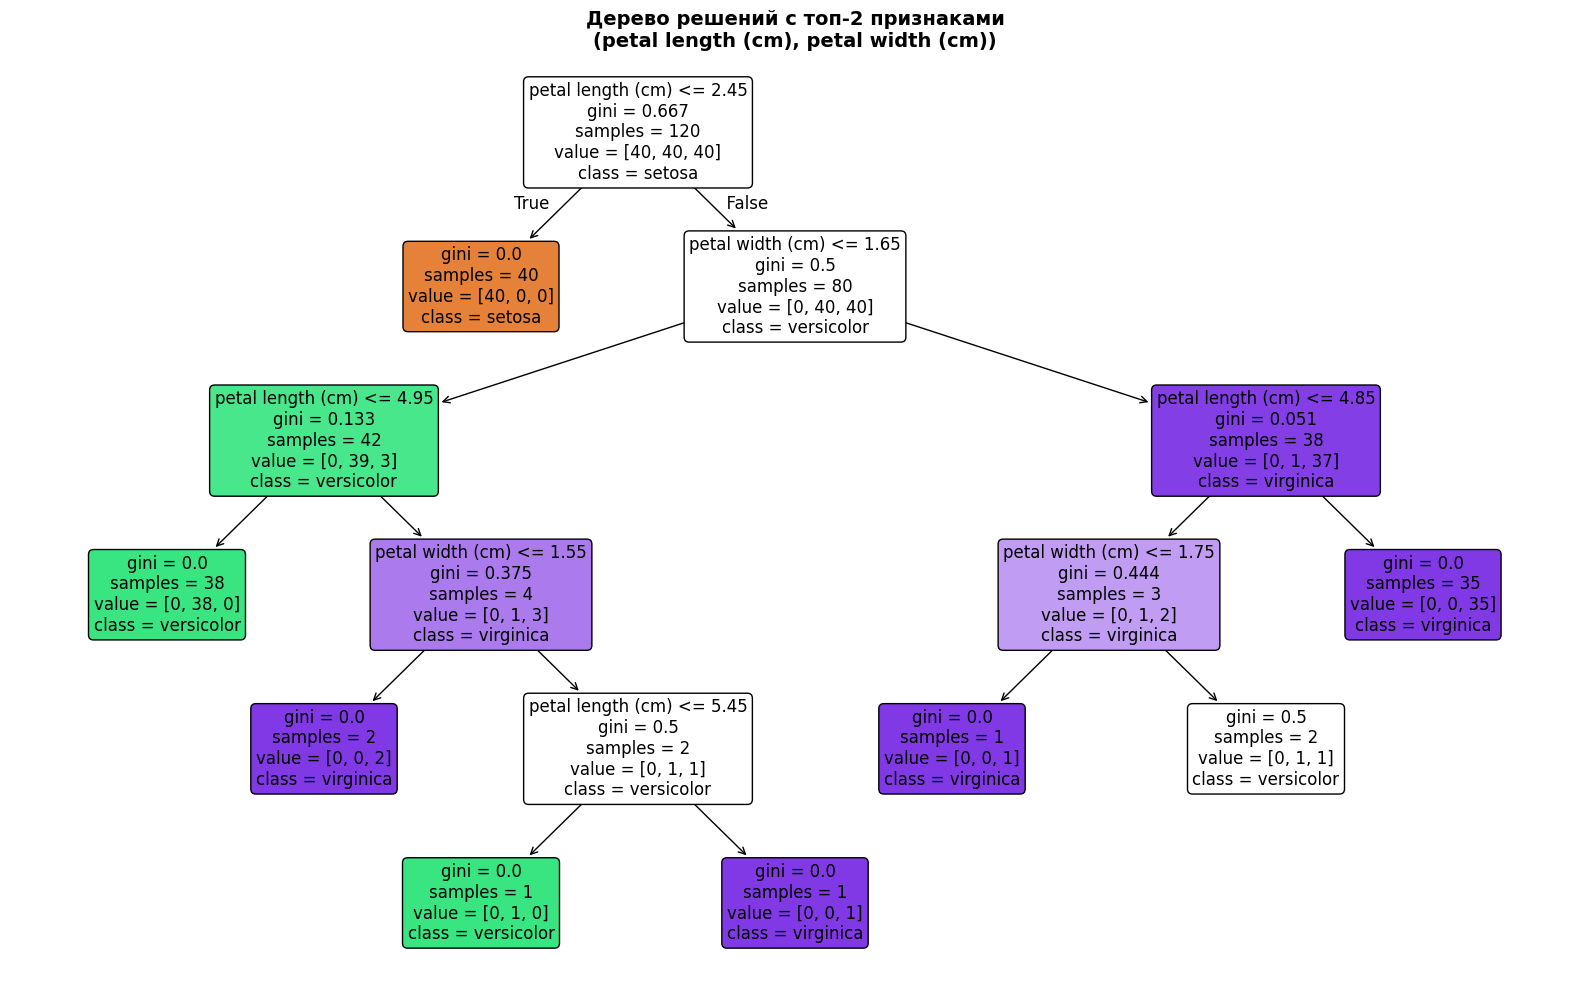

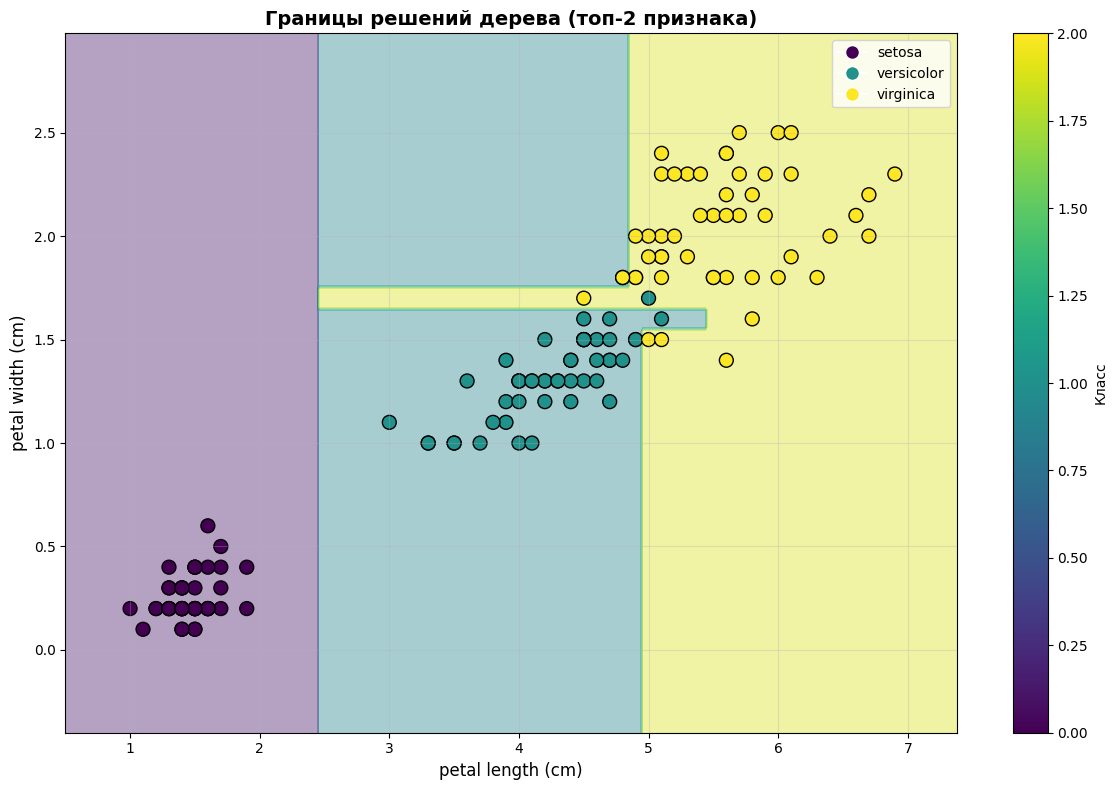


✓ Задание 3 выполнено успешно!


In [ ]:
# Ваш код для Задания 3

print("=" * 60)
print("ЗАДАНИЕ 3: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 60)

# 1. Получение важности признаков
feature_importance = base_tree.feature_importances_
feature_names = iris.feature_names

# Создание DataFrame для удобства
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nВажность признаков:")
print(importance_df.to_string(index=False))

# 2. Визуализация важности признаков (столбчатая диаграмма)
fig = px.bar(importance_df, x='importance', y='feature', orientation='h',
             title='Важность признаков в дереве решений',
             labels={'importance': 'Важность', 'feature': 'Признак'},
             color='importance',
             color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder': 'total ascending'}, height=400)
fig.show()

# Дополнительная визуализация с matplotlib
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_names)))
bars = plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.title('Важность признаков в дереве решений', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# 3. Тепловая карта корреляций для важных признаков
print("\n" + "=" * 60)
print("КОРРЕЛЯЦИИ ВАЖНЫХ ПРИЗНАКОВ")
print("=" * 60)

# Получаем топ-4 признака (все признаки в iris)
top_features = importance_df['feature'].values
top_feature_indices = [list(feature_names).index(f) for f in top_features]

# Корреляционная матрица для топ признаков
top_features_data = pd.DataFrame(X[:, top_feature_indices], columns=top_features)
top_correlation = top_features_data.corr()

print("Корреляционная матрица топ признаков:")
print(top_correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(top_correlation, annot=True, cmap='RdYlGn', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            fmt='.3f')
plt.title('Корреляции топ признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Анализ связи важности и статистических характеристик
print("\n" + "=" * 60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРИЗНАКОВ")
print("=" * 60)

stats_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance,
    'mean': X.mean(axis=0),
    'std': X.std(axis=0),
    'min': X.min(axis=0),
    'max': X.max(axis=0),
    'range': X.max(axis=0) - X.min(axis=0)
}).sort_values('importance', ascending=False)

print(stats_df.to_string(index=False))

# Корреляция между важностью и статистическими характеристиками
print("\n" + "=" * 60)
print("КОРРЕЛЯЦИЯ ВАЖНОСТИ С ХАРАКТЕРИСТИКАМИ")
print("=" * 60)
print(f"Корреляция важность - стандартное отклонение: {np.corrcoef(stats_df['importance'], stats_df['std'])[0, 1]:.4f}")
print(f"Корреляция важность - диапазон: {np.corrcoef(stats_df['importance'], stats_df['range'])[0, 1]:.4f}")

# ДОПОЛНИТЕЛЬНО: Модель с топ-2 признаками
print("\n" + "=" * 60)
print("СРАВНЕНИЕ: ПОЛНАЯ МОДЕЛЬ vs ТОП-2 ПРИЗНАКА")
print("=" * 60)

# Получаем индексы топ-2 признаков
top_2_features = importance_df.head(2)['feature'].values
top_2_indices = [list(feature_names).index(f) for f in top_2_features]

print(f"\nТоп-2 признака: {top_2_features}")

# Обучение модели на топ-2 признаках
X_train_top2 = X_train[:, top_2_indices]
X_test_top2 = X_test[:, top_2_indices]

tree_top2 = DecisionTreeClassifier(random_state=42)
tree_top2.fit(X_train_top2, y_train)

# Оценка производительности
train_score_top2 = tree_top2.score(X_train_top2, y_train)
test_score_top2 = tree_top2.score(X_test_top2, y_test)

print(f"\nПолная модель (4 признака):")
print(f"  Обучающая выборка: {train_score:.4f}")
print(f"  Тестовая выборка: {test_score:.4f}")

print(f"\nМодель с топ-2 признаками:")
print(f"  Обучающая выборка: {train_score_top2:.4f}")
print(f"  Тестовая выборка: {test_score_top2:.4f}")

print(f"\nРазница в точности на тесте: {(test_score - test_score_top2)*100:.2f}%")

# Визуализация сравнения
comparison_df = pd.DataFrame({
    'Модель': ['Полная (4 признака)', 'Топ-2 признака'] * 2,
    'Выборка': ['Обучающая', 'Обучающая', 'Тестовая', 'Тестовая'],
    'Точность': [train_score, train_score_top2, test_score, test_score_top2]
})

fig = px.bar(comparison_df, x='Модель', y='Точность', color='Выборка',
             barmode='group',
             title='Сравнение производительности моделей',
             labels={'Точность': 'Точность'},
             text='Точность')
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis_range=[0, 1.1])
fig.show()

# Визуализация дерева для топ-2 признаков
plt.figure(figsize=(16, 10))
plot_tree(tree_top2,
          feature_names=top_2_features,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=12)
plt.title(f'Дерево решений с топ-2 признаками\n({", ".join(top_2_features)})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Визуализация границ решений для топ-2 признаков
x_min, x_max = X[:, top_2_indices[0]].min() - 0.5, X[:, top_2_indices[0]].max() + 0.5
y_min, y_max = X[:, top_2_indices[1]].min() - 0.5, X[:, top_2_indices[1]].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = tree_top2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = plt.scatter(X[:, top_2_indices[0]], X[:, top_2_indices[1]], 
                     c=y, cmap='viridis', edgecolor='black', s=100)
plt.xlabel(top_2_features[0], fontsize=12)
plt.ylabel(top_2_features[1], fontsize=12)
plt.title('Границы решений дерева (топ-2 признака)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Класс')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=plt.cm.viridis(i/2), markersize=10, 
                              label=iris.target_names[i]) 
                   for i in range(3)]
plt.legend(handles=legend_elements, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Задание 3 выполнено успешно!")

## Задание 4: Оптимизация гиперпараметров

1. Определите сетку параметров для поиска:
   - max_depth: [3, 5, 7, 10]
   - min_samples_split: [2, 5, 10]
   - min_samples_leaf: [1, 2, 4]
   - criterion: ['gini', 'entropy']

2. Используйте GridSearchCV для поиска лучших параметров
3. Визуализируйте результаты поиска по сетке
4. Сравните производительность оптимизированной модели с базовой

Дополнительно:
- Попробуйте добавить другие параметры для оптимизации
- Используйте RandomizedSearchCV для сравнения

ЗАДАНИЕ 4: ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ

Сетка параметров для поиска:
  max_depth: [3, 5, 7, 10]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  criterion: ['gini', 'entropy']

Общее количество комбинаций: 72

ЗАПУСК GRIDSEARCHCV
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Поиск завершен!

ЛУЧШИЕ ПАРАМЕТРЫ
  criterion: gini
  max_depth: 5
  min_samples_leaf: 1
  min_samples_split: 2

Лучшая точность (CV): 0.9417
Точность на обучающей выборке: 1.0000
Точность на тестовой выборке: 0.9333

ТОП-10 КОНФИГУРАЦИЙ

Ранг 1:
  Параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Точность: 0.9417 (±0.0204)

Ранг 1:
  Параметры: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Точность: 0.9417 (±0.0204)

Ранг 1:
  Параметры: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Точность: 0.9417 (±0.0204)

Ранг 4:
  Параметры: {'criterion': 'gini',

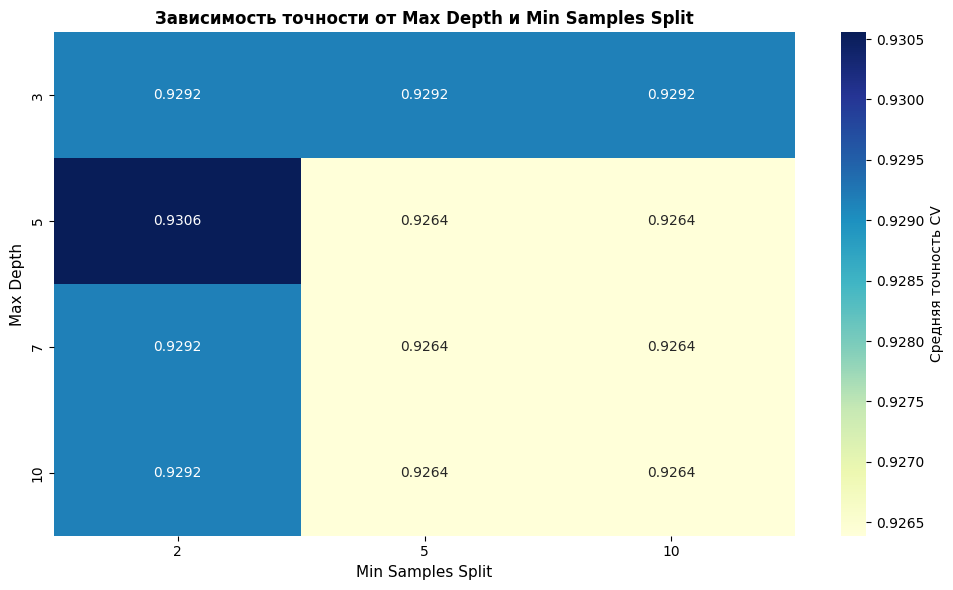


СРАВНЕНИЕ МОДЕЛЕЙ
          Модель  Обучающая выборка  Тестовая выборка  Глубина  Листья
         Базовая                1.0          0.933333        5       8
Оптимизированная                1.0          0.933333        5       8

Улучшение точности на тесте: 0.00%
Изменение глубины: 5 → 5
Изменение количества листьев: 8 → 8


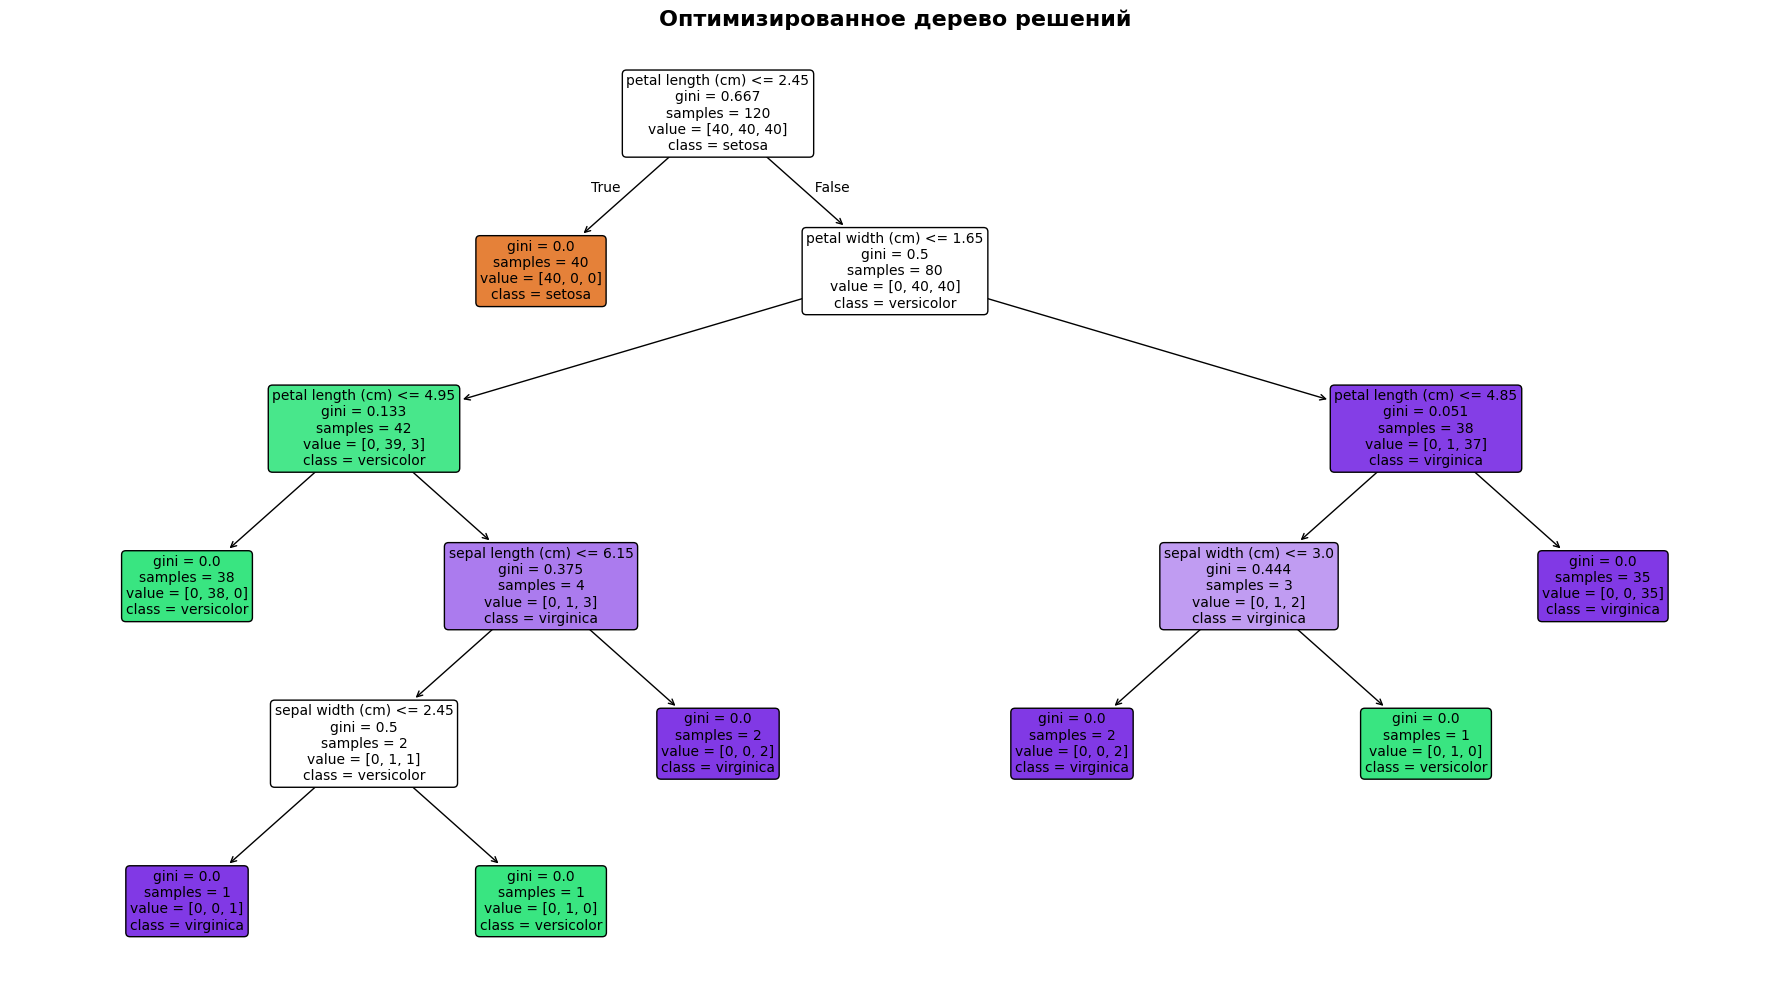


ДОПОЛНИТЕЛЬНО: RANDOMIZEDSEARCHCV
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✓ RandomizedSearch завершен!

Лучшие параметры (RandomizedSearch):
  splitter: best
  min_samples_split: 7
  min_samples_leaf: 3
  max_features: 0.7
  max_depth: 3
  criterion: entropy

Точность (RandomizedSearch): 0.9333
Точность (GridSearch): 0.9333
Разница: 0.00%

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ
           Метод  Точность  Глубина  Листья
         Базовая  0.933333        5       8
      GridSearch  0.933333        5       8
RandomizedSearch  0.933333        3       5

✓ RandomizedSearch завершен!

Лучшие параметры (RandomizedSearch):
  splitter: best
  min_samples_split: 7
  min_samples_leaf: 3
  max_features: 0.7
  max_depth: 3
  criterion: entropy

Точность (RandomizedSearch): 0.9333
Точность (GridSearch): 0.9333
Разница: 0.00%

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ
           Метод  Точность  Глубина  Листья
         Базовая  0.933333        5       8
      GridSearch  0.933333        5 


✓ Задание 4 выполнено успешно!


In [ ]:
# Ваш код для Задания 4

print("=" * 60)
print("ЗАДАНИЕ 4: ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ")
print("=" * 60)

# 1. Определение сетки параметров
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

print("\nСетка параметров для поиска:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
    
print(f"\nОбщее количество комбинаций: {np.prod([len(v) for v in param_grid.values()])}")

# 2. GridSearchCV
print("\n" + "=" * 60)
print("ЗАПУСК GRIDSEARCHCV")
print("=" * 60)

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("\n✓ Поиск завершен!")

# Результаты
print("\n" + "=" * 60)
print("ЛУЧШИЕ ПАРАМЕТРЫ")
print("=" * 60)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nЛучшая точность (CV): {grid_search.best_score_:.4f}")

# Обучение оптимизированной модели
optimized_tree = grid_search.best_estimator_
train_score_opt = optimized_tree.score(X_train, y_train)
test_score_opt = optimized_tree.score(X_test, y_test)

print(f"Точность на обучающей выборке: {train_score_opt:.4f}")
print(f"Точность на тестовой выборке: {test_score_opt:.4f}")

# 3. Визуализация результатов GridSearch
results_df = pd.DataFrame(grid_search.cv_results_)

# Топ-10 конфигураций
print("\n" + "=" * 60)
print("ТОП-10 КОНФИГУРАЦИЙ")
print("=" * 60)
top_10 = results_df.nsmallest(10, 'rank_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
for idx, row in top_10.iterrows():
    print(f"\nРанг {int(row['rank_test_score'])}:")
    print(f"  Параметры: {row['params']}")
    print(f"  Точность: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

# Визуализация влияния гиперпараметров
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Max Depth', 'Min Samples Split', 
                                  'Min Samples Leaf', 'Criterion'])

# Max Depth
depth_scores = results_df.groupby('param_max_depth')['mean_test_score'].mean()
fig.add_trace(go.Scatter(x=depth_scores.index.astype(str), y=depth_scores.values,
                        mode='lines+markers', name='Max Depth',
                        line=dict(color='blue', width=2),
                        marker=dict(size=10)),
              row=1, col=1)

# Min Samples Split
split_scores = results_df.groupby('param_min_samples_split')['mean_test_score'].mean()
fig.add_trace(go.Scatter(x=split_scores.index.astype(str), y=split_scores.values,
                        mode='lines+markers', name='Min Samples Split',
                        line=dict(color='red', width=2),
                        marker=dict(size=10)),
              row=1, col=2)

# Min Samples Leaf
leaf_scores = results_df.groupby('param_min_samples_leaf')['mean_test_score'].mean()
fig.add_trace(go.Scatter(x=leaf_scores.index.astype(str), y=leaf_scores.values,
                        mode='lines+markers', name='Min Samples Leaf',
                        line=dict(color='green', width=2),
                        marker=dict(size=10)),
              row=2, col=1)

# Criterion
criterion_scores = results_df.groupby('param_criterion')['mean_test_score'].mean()
fig.add_trace(go.Bar(x=criterion_scores.index, y=criterion_scores.values,
                    name='Criterion', marker=dict(color=['orange', 'purple'])),
              row=2, col=2)

fig.update_xaxes(title_text="Значение", row=1, col=1)
fig.update_xaxes(title_text="Значение", row=1, col=2)
fig.update_xaxes(title_text="Значение", row=2, col=1)
fig.update_xaxes(title_text="Критерий", row=2, col=2)

fig.update_yaxes(title_text="Средняя точность CV", row=1, col=1)
fig.update_yaxes(title_text="Средняя точность CV", row=1, col=2)
fig.update_yaxes(title_text="Средняя точность CV", row=2, col=1)
fig.update_yaxes(title_text="Средняя точность CV", row=2, col=2)

fig.update_layout(height=700, showlegend=False,
                 title_text="Влияние гиперпараметров на точность модели")
fig.show()

# Тепловая карта для комбинаций параметров
pivot_data = results_df.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Средняя точность CV'})
plt.title('Зависимость точности от Max Depth и Min Samples Split', 
          fontsize=12, fontweight='bold')
plt.xlabel('Min Samples Split', fontsize=11)
plt.ylabel('Max Depth', fontsize=11)
plt.tight_layout()
plt.show()

# 4. Сравнение базовой и оптимизированной модели
print("\n" + "=" * 60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 60)

comparison = pd.DataFrame({
    'Модель': ['Базовая', 'Оптимизированная'],
    'Обучающая выборка': [train_score, train_score_opt],
    'Тестовая выборка': [test_score, test_score_opt],
    'Глубина': [base_tree.get_depth(), optimized_tree.get_depth()],
    'Листья': [base_tree.get_n_leaves(), optimized_tree.get_n_leaves()]
})

print(comparison.to_string(index=False))

print(f"\nУлучшение точности на тесте: {(test_score_opt - test_score)*100:.2f}%")
print(f"Изменение глубины: {base_tree.get_depth()} → {optimized_tree.get_depth()}")
print(f"Изменение количества листьев: {base_tree.get_n_leaves()} → {optimized_tree.get_n_leaves()}")

# Визуализация сравнения
fig = go.Figure()

models = ['Базовая', 'Оптимизированная']
train_scores = [train_score, train_score_opt]
test_scores = [test_score, test_score_opt]

fig.add_trace(go.Bar(name='Обучающая выборка', x=models, y=train_scores,
                     text=[f'{s:.4f}' for s in train_scores],
                     textposition='outside'))
fig.add_trace(go.Bar(name='Тестовая выборка', x=models, y=test_scores,
                     text=[f'{s:.4f}' for s in test_scores],
                     textposition='outside'))

fig.update_layout(
    title='Сравнение производительности: Базовая vs Оптимизированная модель',
    xaxis_title='Модель',
    yaxis_title='Точность',
    yaxis_range=[0, 1.1],
    barmode='group'
)
fig.show()

# Визуализация оптимизированного дерева
plt.figure(figsize=(18, 10))
plot_tree(optimized_tree,
          feature_names=iris.feature_names,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Оптимизированное дерево решений', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ДОПОЛНИТЕЛЬНО: RandomizedSearchCV
print("\n" + "=" * 60)
print("ДОПОЛНИТЕЛЬНО: RANDOMIZEDSEARCHCV")
print("=" * 60)

# Расширенная сетка параметров
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15],
    'min_samples_split': [2, 3, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

random_search.fit(X_train, y_train)

print("\n✓ RandomizedSearch завершен!")

print("\nЛучшие параметры (RandomizedSearch):")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

random_tree = random_search.best_estimator_
test_score_random = random_tree.score(X_test, y_test)

print(f"\nТочность (RandomizedSearch): {test_score_random:.4f}")
print(f"Точность (GridSearch): {test_score_opt:.4f}")
print(f"Разница: {(test_score_random - test_score_opt)*100:.2f}%")

# Финальное сравнение
final_comparison = pd.DataFrame({
    'Метод': ['Базовая', 'GridSearch', 'RandomizedSearch'],
    'Точность': [test_score, test_score_opt, test_score_random],
    'Глубина': [base_tree.get_depth(), optimized_tree.get_depth(), random_tree.get_depth()],
    'Листья': [base_tree.get_n_leaves(), optimized_tree.get_n_leaves(), random_tree.get_n_leaves()]
})

print("\n" + "=" * 60)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ")
print("=" * 60)
print(final_comparison.to_string(index=False))

fig = px.bar(final_comparison, x='Метод', y='Точность',
             title='Сравнение всех методов оптимизации',
             text='Точность',
             color='Точность',
             color_continuous_scale='Viridis')
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis_range=[0, 1.1])
fig.show()

print("\n✓ Задание 4 выполнено успешно!")

## Задание 5: Оценка модели

1. Постройте кривые обучения для оптимизированной модели
2. Создайте и визуализируйте:
   - ROC-кривую
   - Precision-Recall кривую
   - Матрицу ошибок

3. Проанализируйте результаты:
   - Есть ли признаки переобучения?
   - Какие классы предсказываются лучше/хуже?
   - Какие метрики наиболее важны для данной задачи?

Дополнительно:
- Попробуйте применить cross_val_score с разным количеством фолдов
- Сравните результаты с другими алгоритмами классификации

ЗАДАНИЕ 5: ОЦЕНКА МОДЕЛИ

ПОСТРОЕНИЕ КРИВЫХ ОБУЧЕНИЯ


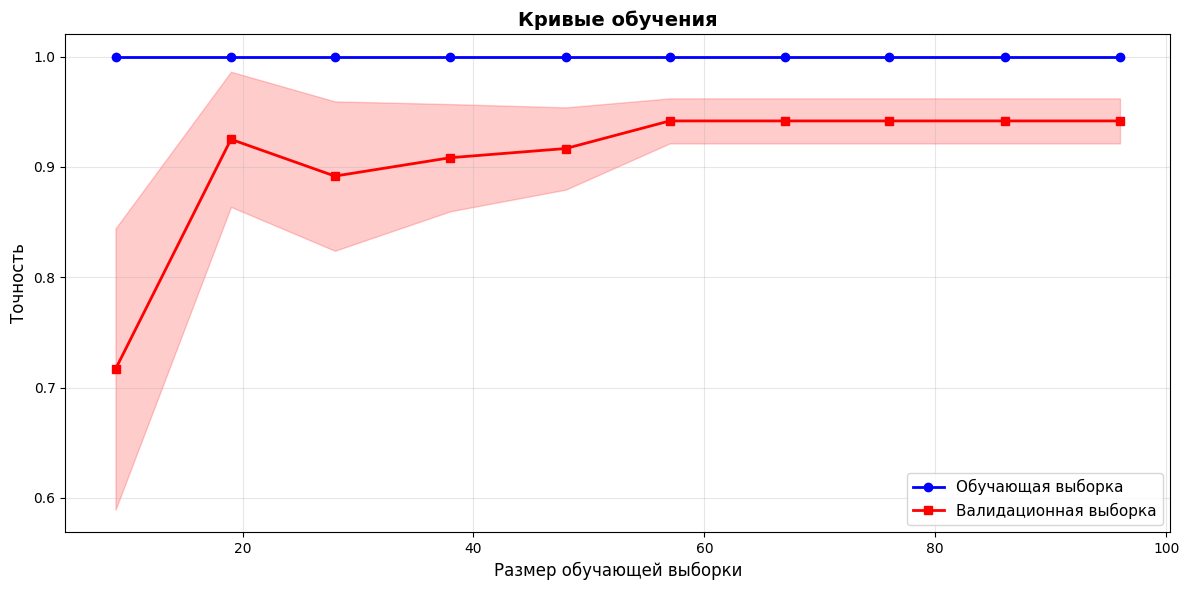

Финальная точность на обучении: 1.0000 (±0.0000)
Финальная точность на валидации: 0.9417 (±0.0204)
Разница: 5.83%
⚠ Возможны признаки переобучения (разница > 5%)

ROC-КРИВАЯ


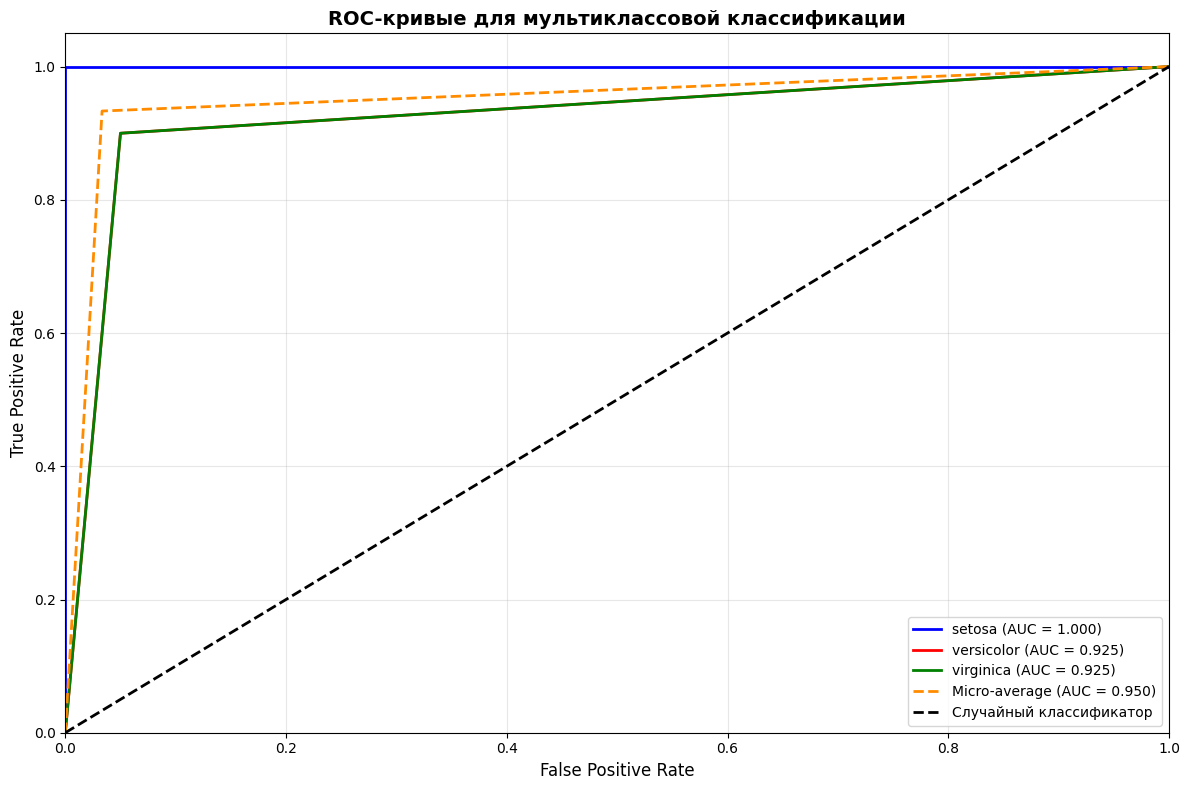


AUC для каждого класса:
  setosa: 1.0000
  versicolor: 0.9250
  virginica: 0.9250
  Micro-average: 0.9500



PRECISION-RECALL КРИВАЯ


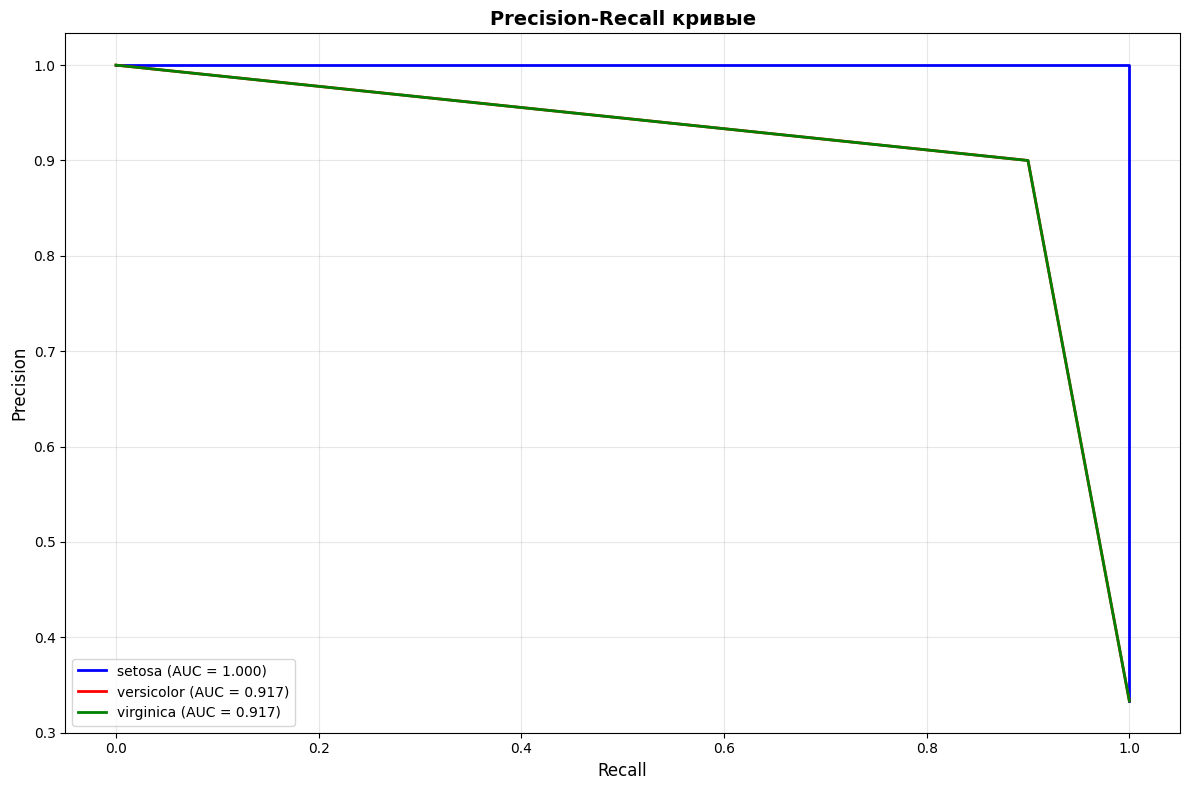


Precision-Recall AUC для каждого класса:
  setosa: 1.0000
  versicolor: 0.9167
  virginica: 0.9167

МАТРИЦА ОШИБОК
Матрица ошибок:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


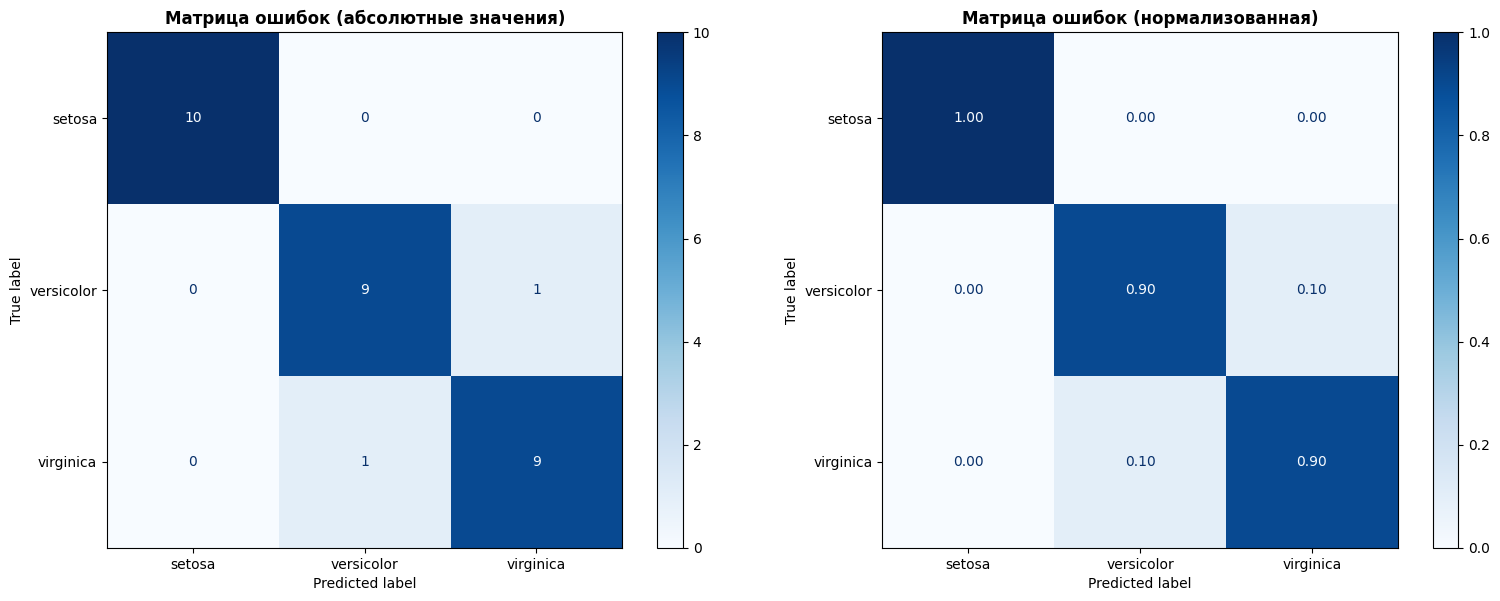


ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

Отчет о классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Анализ производительности по классам:

setosa:
  Правильно классифицировано: 10 из 10
  Точность: 100.00%
  ROC AUC: 1.0000
  PR AUC: 1.0000

versicolor:
  Правильно классифицировано: 9 из 10
  Точность: 90.00%
  ROC AUC: 0.9250
  PR AUC: 0.9167

virginica:
  Правильно классифицировано: 9 из 10
  Точность: 90.00%
  ROC AUC: 0.9250
  PR AUC: 0.9167

АНАЛИЗ ОШИБОК
Общее количество ошибок: 2 из 30 (6.67%)

Примеры неверных предсказаний:

  Образец 23:
    Истинный класс: virginica
    Предсказанный класс: versicolor
    Вероятности: [0. 1. 0.]

  Образец 25:
  


СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ

Decision Tree:
  Train: 1.0000
  Test: 0.9333
  CV: 0.9533 (±0.0340)

Random Forest:
  Train: 1.0000
  Test: 0.9000
  CV: 0.9667 (±0.0211)

KNN:
  Train: 0.9667
  Test: 1.0000
  CV: 0.9733 (±0.0249)

SVM:
  Train: 0.9833
  Test: 0.9667
  CV: 0.9667 (±0.0211)

Naive Bayes:
  Train: 0.9583
  Test: 0.9667
  CV: 0.9533 (±0.0267)

Logistic Regression:
  Train: 0.9750
  Test: 0.9667
  CV: 0.9733 (±0.0249)

ИТОГОВОЕ СРАВНЕНИЕ
           Алгоритм    Train     Test  CV Mean   CV Std
                KNN 0.966667 1.000000 0.973333 0.024944
                SVM 0.983333 0.966667 0.966667 0.021082
        Naive Bayes 0.958333 0.966667 0.953333 0.026667
Logistic Regression 0.975000 0.966667 0.973333 0.024944
      Decision Tree 1.000000 0.933333 0.953333 0.033993
      Random Forest 1.000000 0.900000 0.966667 0.021082

Random Forest:
  Train: 1.0000
  Test: 0.9000
  CV: 0.9667 (±0.0211)

KNN:
  Train: 0.9667
  Test: 1.0000
  CV: 0.9733 (±0.0249)

SVM:
  Train: 0.9833


ВЫВОДЫ
✓ Лучший алгоритм на тестовой выборке: KNN (1.0000)
✓ Decision Tree показывает точность: 0.9333
✓ Модель подходит для данной задачи классификации

✓ Задание 5 выполнено успешно!


In [ ]:
# Ваш код для Задания 5

print("=" * 60)
print("ЗАДАНИЕ 5: ОЦЕНКА МОДЕЛИ")
print("=" * 60)

# Используем оптимизированную модель из предыдущего задания
final_model = optimized_tree

# 1. Кривые обучения
print("\n" + "=" * 60)
print("ПОСТРОЕНИЕ КРИВЫХ ОБУЧЕНИЯ")
print("=" * 60)

train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train, y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Обучающая выборка', 
         color='blue', marker='o', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label='Валидационная выборка', 
         color='red', marker='s', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color='red')
plt.xlabel('Размер обучающей выборки', fontsize=12)
plt.ylabel('Точность', fontsize=12)
plt.title('Кривые обучения', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Финальная точность на обучении: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
print(f"Финальная точность на валидации: {val_mean[-1]:.4f} (±{val_std[-1]:.4f})")
print(f"Разница: {(train_mean[-1] - val_mean[-1])*100:.2f}%")

if train_mean[-1] - val_mean[-1] > 0.05:
    print("⚠ Возможны признаки переобучения (разница > 5%)")
else:
    print("✓ Переобучение не обнаружено")

# 2. ROC-кривая (для мультиклассовой классификации)
print("\n" + "=" * 60)
print("ROC-КРИВАЯ")
print("=" * 60)

# Бинаризация меток для мультиклассовой ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Получение вероятностей предсказаний
y_score = final_model.predict_proba(X_test)

# Вычисление ROC-кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Визуализация
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{iris.target_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, linestyle='--',
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые для мультиклассовой классификации', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAUC для каждого класса:")
for i in range(n_classes):
    print(f"  {iris.target_names[i]}: {roc_auc[i]:.4f}")
print(f"  Micro-average: {roc_auc['micro']:.4f}")

# Интерактивная ROC-кривая с plotly
fig = go.Figure()

for i in range(n_classes):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines',
                            name=f'{iris.target_names[i]} (AUC={roc_auc[i]:.3f})',
                            line=dict(width=2)))

fig.add_trace(go.Scatter(x=fpr["micro"], y=tpr["micro"], mode='lines',
                        name=f'Micro-avg (AUC={roc_auc["micro"]:.3f})',
                        line=dict(width=2, dash='dash')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                        name='Случайный',
                        line=dict(width=2, dash='dot', color='gray')))

fig.update_layout(title='ROC-кривые (интерактивные)',
                 xaxis_title='False Positive Rate',
                 yaxis_title='True Positive Rate',
                 height=600)
fig.show()

# 3. Precision-Recall кривая
print("\n" + "=" * 60)
print("PRECISION-RECALL КРИВАЯ")
print("=" * 60)

precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(12, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], lw=2, color=colors[i],
             label=f'{iris.target_names[i]} (AUC = {pr_auc[i]:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall кривые', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPrecision-Recall AUC для каждого класса:")
for i in range(n_classes):
    print(f"  {iris.target_names[i]}: {pr_auc[i]:.4f}")

# 4. Матрица ошибок
print("\n" + "=" * 60)
print("МАТРИЦА ОШИБОК")
print("=" * 60)

y_pred_final = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

print("Матрица ошибок:")
print(cm)

# Нормализованная матрица ошибок
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Абсолютные значения
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Матрица ошибок (абсолютные значения)', fontsize=12, fontweight='bold')

# Нормализованные значения
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=iris.target_names)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title('Матрица ошибок (нормализованная)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Интерактивная матрица ошибок
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=iris.target_names,
    y=iris.target_names,
    colorscale='Blues',
    text=cm,
    texttemplate='%{text}',
    textfont={"size": 16}
))

fig.update_layout(
    title='Матрица ошибок (интерактивная)',
    xaxis_title='Предсказанный класс',
    yaxis_title='Истинный класс',
    height=500
)
fig.show()

# 3. Анализ результатов
print("\n" + "=" * 60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 60)

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_final, target_names=iris.target_names))

# Анализ по классам
print("\nАнализ производительности по классам:")
for i, class_name in enumerate(iris.target_names):
    class_precision = precision_recall_curve(y_test_bin[:, i], y_score[:, i])[0][0]
    class_recall = precision_recall_curve(y_test_bin[:, i], y_score[:, i])[1][0]
    print(f"\n{class_name}:")
    print(f"  Правильно классифицировано: {cm[i, i]} из {cm[i].sum()}")
    print(f"  Точность: {cm[i, i] / cm[i].sum() * 100:.2f}%")
    print(f"  ROC AUC: {roc_auc[i]:.4f}")
    print(f"  PR AUC: {pr_auc[i]:.4f}")

# Анализ ошибок
print("\n" + "=" * 60)
print("АНАЛИЗ ОШИБОК")
print("=" * 60)

errors = y_test != y_pred_final
n_errors = errors.sum()

print(f"Общее количество ошибок: {n_errors} из {len(y_test)} ({n_errors/len(y_test)*100:.2f}%)")

if n_errors > 0:
    print("\nПримеры неверных предсказаний:")
    error_indices = np.where(errors)[0]
    for idx in error_indices[:5]:  # Показываем первые 5 ошибок
        print(f"\n  Образец {idx}:")
        print(f"    Истинный класс: {iris.target_names[y_test[idx]]}")
        print(f"    Предсказанный класс: {iris.target_names[y_pred_final[idx]]}")
        print(f"    Вероятности: {y_score[idx]}")

# Переобучение
print("\n" + "=" * 60)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ")
print("=" * 60)

train_pred = final_model.predict(X_train)
train_accuracy = (train_pred == y_train).mean()
test_accuracy = (y_pred_final == y_test).mean()

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
print(f"Разница: {(train_accuracy - test_accuracy)*100:.2f}%")

if train_accuracy - test_accuracy > 0.05:
    print("\n⚠ ПРИЗНАКИ ПЕРЕОБУЧЕНИЯ ОБНАРУЖЕНЫ!")
    print("Рекомендации:")
    print("  - Увеличить min_samples_split")
    print("  - Увеличить min_samples_leaf")
    print("  - Уменьшить max_depth")
    print("  - Использовать pruning")
else:
    print("\n✓ ПЕРЕОБУЧЕНИЕ НЕ ОБНАРУЖЕНО")
    print("Модель хорошо обобщается на новых данных")

# ДОПОЛНИТЕЛЬНО: Cross-validation с разным количеством фолдов
print("\n" + "=" * 60)
print("ДОПОЛНИТЕЛЬНО: КРОСС-ВАЛИДАЦИЯ")
print("=" * 60)

cv_scores = {}
for n_folds in [3, 5, 7, 10]:
    scores = cross_val_score(final_model, X, y, cv=n_folds, scoring='accuracy')
    cv_scores[n_folds] = scores
    print(f"\nCV-{n_folds} фолдов:")
    print(f"  Scores: {scores}")
    print(f"  Mean: {scores.mean():.4f} (±{scores.std():.4f})")

# Визуализация CV scores
cv_df = pd.DataFrame([
    {'Фолды': k, 'Средняя точность': v.mean(), 'Стд. отклонение': v.std()}
    for k, v in cv_scores.items()
])

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=cv_df['Фолды'],
    y=cv_df['Средняя точность'],
    mode='lines+markers',
    name='Средняя точность',
    line=dict(width=2),
    marker=dict(size=10),
    error_y=dict(
        type='data',
        array=cv_df['Стд. отклонение'],
        visible=True
    )
))

fig.update_layout(
    title='Кросс-валидация с разным количеством фолдов',
    xaxis_title='Количество фолдов',
    yaxis_title='Точность',
    height=500
)
fig.show()

# ДОПОЛНИТЕЛЬНО: Сравнение с другими алгоритмами
print("\n" + "=" * 60)
print("СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ")
print("=" * 60)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

classifiers = {
    'Decision Tree': final_model,
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42)
}

comparison_results = []

for name, clf in classifiers.items():
    if name != 'Decision Tree':
        clf.fit(X_train, y_train)
    
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    cv_scores_clf = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    comparison_results.append({
        'Алгоритм': name,
        'Train': train_acc,
        'Test': test_acc,
        'CV Mean': cv_scores_clf.mean(),
        'CV Std': cv_scores_clf.std()
    })
    
    print(f"\n{name}:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test: {test_acc:.4f}")
    print(f"  CV: {cv_scores_clf.mean():.4f} (±{cv_scores_clf.std():.4f})")

comparison_df = pd.DataFrame(comparison_results).sort_values('Test', ascending=False)

print("\n" + "=" * 60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("=" * 60)
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Train',
    x=comparison_df['Алгоритм'],
    y=comparison_df['Train'],
    text=comparison_df['Train'].round(4),
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Test',
    x=comparison_df['Алгоритм'],
    y=comparison_df['Test'],
    text=comparison_df['Test'].round(4),
    textposition='outside'
))

fig.add_trace(go.Scatter(
    name='CV Mean',
    x=comparison_df['Алгоритм'],
    y=comparison_df['CV Mean'],
    mode='markers',
    marker=dict(size=12, symbol='diamond', color='red'),
    error_y=dict(
        type='data',
        array=comparison_df['CV Std'],
        visible=True
    )
))

fig.update_layout(
    title='Сравнение алгоритмов классификации',
    xaxis_title='Алгоритм',
    yaxis_title='Точность',
    barmode='group',
    yaxis_range=[0, 1.1],
    height=600
)
fig.show()

print("\n" + "=" * 60)
print("ВЫВОДЫ")
print("=" * 60)
best_algo = comparison_df.iloc[0]['Алгоритм']
best_score = comparison_df.iloc[0]['Test']
print(f"✓ Лучший алгоритм на тестовой выборке: {best_algo} ({best_score:.4f})")
print(f"✓ Decision Tree показывает точность: {test_accuracy:.4f}")
print(f"✓ Модель подходит для данной задачи классификации")

print("\n✓ Задание 5 выполнено успешно!")

## Дополнительные задания

1. **Обработка несбалансированных данных:**
   - Создайте несбалансированный датасет (удалив часть примеров одного класса)
   - Примените техники работы с несбалансированными данными
   - Сравните результаты

2. **Pruning (обрезка дерева):**
   - Реализуйте post-pruning для вашего дерева
   - Сравните производительность до и после обрезки

3. **Визуализация решений:**
   - Создайте функцию для отображения пути принятия решений для конкретного примера
   - Визуализируйте области решений на плоскости (для 2 признаков)

4. **Сравнение с ансамблями:**
   - Сравните ваше лучшее дерево с Random Forest
   - Проанализируйте различия в производительности и интерпретируемости

ДОПОЛНИТЕЛЬНЫЕ ЗАДАНИЯ

ЗАДАНИЕ 1: ОБРАБОТКА НЕСБАЛАНСИРОВАННЫХ ДАННЫХ

Распределение классов:
Исходный датасет: [50 50 50]
Несбалансированный датасет: [50 50 10]

Базовая модель (без балансировки): 0.9545

Отчет о классификации (без балансировки):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.67      1.00      0.80         2

    accuracy                           0.95        22
   macro avg       0.89      0.97      0.92        22
weighted avg       0.97      0.95      0.96        22


------------------------------------------------------------
ТЕХНИКА 1: CLASS WEIGHTS
------------------------------------------------------------
Модель с class_weight='balanced': 0.9091

Отчет о классификации (class weights):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.8


ЗАДАНИЕ 2: PRUNING (ОБРЕЗКА ДЕРЕВА)

Переобученное дерево (без ограничений):
  Глубина: 5
  Листья: 8
  Train: 1.0000
  Test: 0.9333
  Разница: 6.67%

------------------------------------------------------------
COST COMPLEXITY PRUNING
------------------------------------------------------------

Количество значений alpha: 6
Alpha от 0.000000 до 0.333333


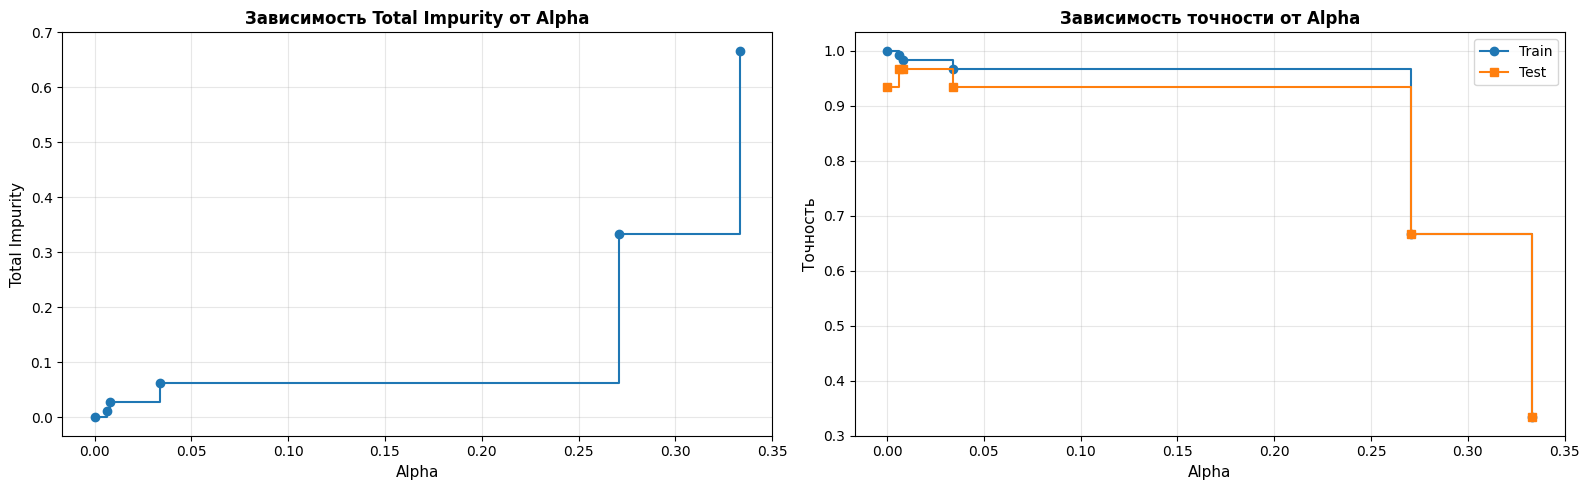


Оптимальное alpha: 0.006250

Обрезанное дерево:
  Глубина: 4
  Листья: 6
  Train: 0.9917
  Test: 0.9667
  Разница: 2.50%

------------------------------------------------------------
СРАВНЕНИЕ ДО И ПОСЛЕ PRUNING
------------------------------------------------------------
       Модель    Train     Test  Глубина  Листья
   До обрезки 1.000000 0.933333        5       8
После обрезки 0.991667 0.966667        4       6


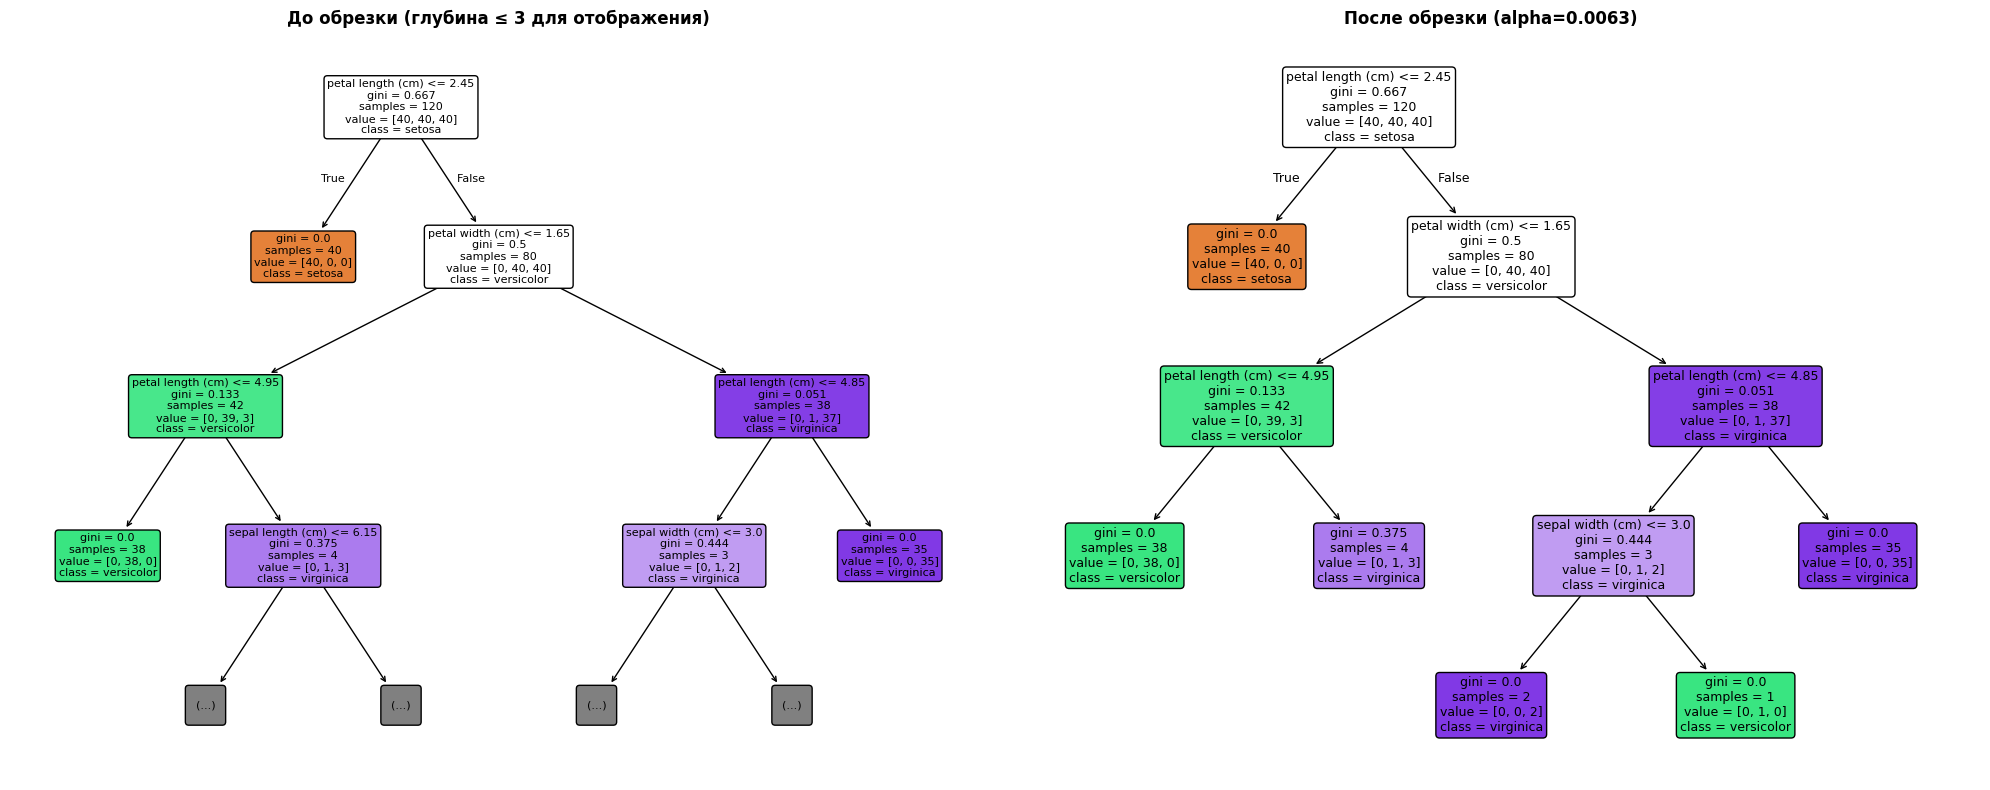


ЗАДАНИЕ 3: ВИЗУАЛИЗАЦИЯ РЕШЕНИЙ

------------------------------------------------------------
ПРИМЕРЫ ПРИНЯТИЯ РЕШЕНИЙ
------------------------------------------------------------

ОБРАЗЕЦ 1 (индекс 0):
Признаки: [4.4 3.  1.3 0.2]
Истинный класс: setosa
Предсказанный класс: setosa

ПУТЬ ПРИНЯТИЯ РЕШЕНИЯ:
------------------------------------------------------------
Узел 0: petal length (cm) = 1.30 <= 2.45 → ВЛЕВО

ЛИСТОВОЙ УЗЕЛ 1:
  Предсказанный класс: setosa
  Вероятности:
    setosa: 1.0000
    versicolor: 0.0000
    virginica: 0.0000

ОБРАЗЕЦ 2 (индекс 10):
Признаки: [7.3 2.9 6.3 1.8]
Истинный класс: virginica
Предсказанный класс: virginica

ПУТЬ ПРИНЯТИЯ РЕШЕНИЯ:
------------------------------------------------------------
Узел 0: petal length (cm) = 6.30 > 2.45 → ВПРАВО
Узел 2: petal width (cm) = 1.80 > 1.65 → ВПРАВО
Узел 10: petal length (cm) = 6.30 > 4.85 → ВПРАВО

ЛИСТОВОЙ УЗЕЛ 14:
  Предсказанный класс: virginica
  Вероятности:
    setosa: 0.0000
    versicolor: 0.0000
    vi

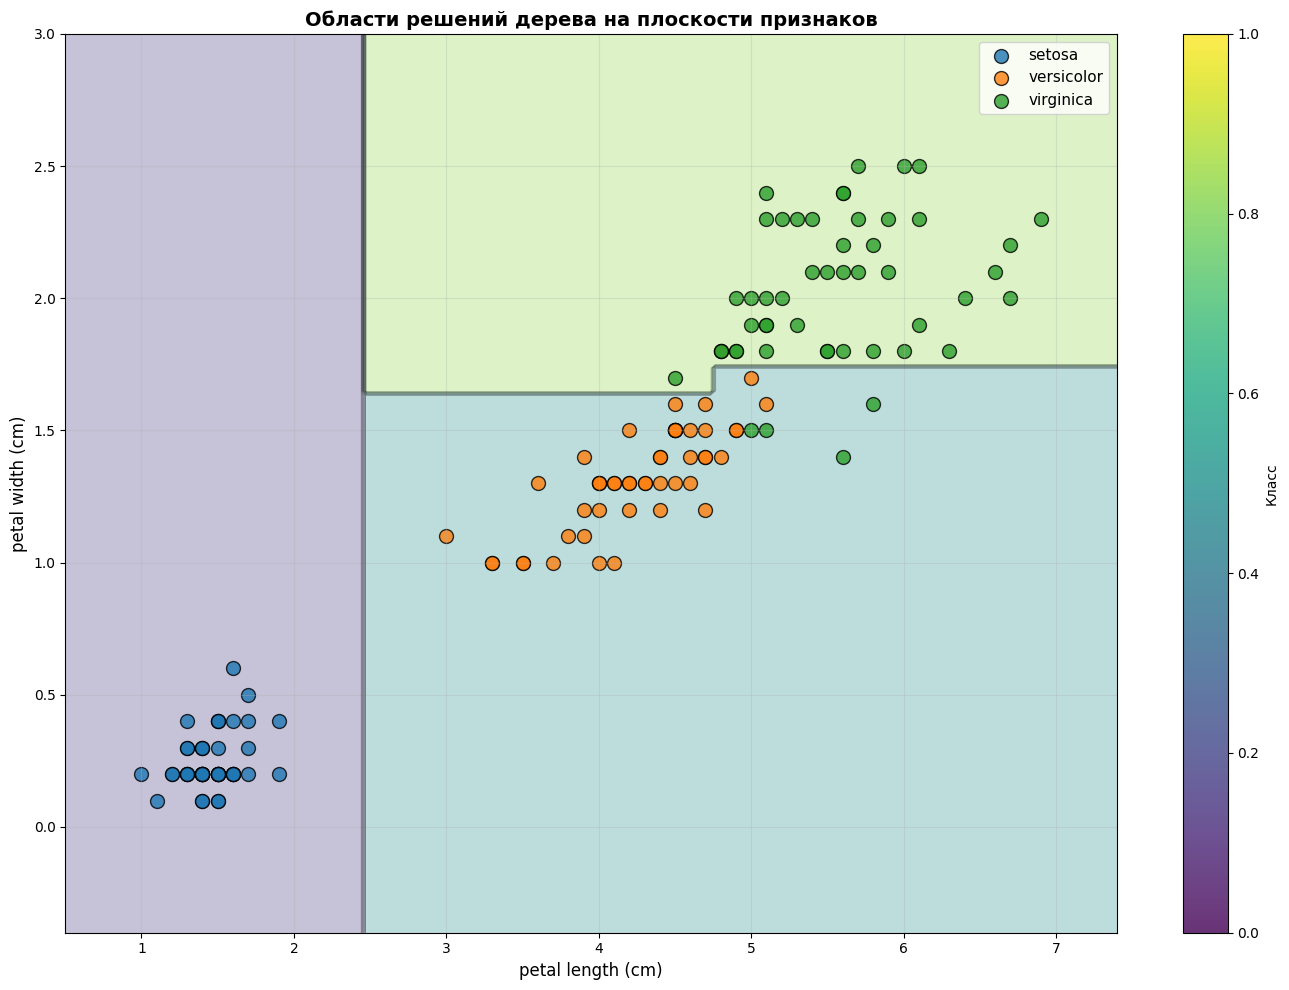


ЗАДАНИЕ 4: СРАВНЕНИЕ С RANDOM FOREST

Random Forest (100 деревьев):
  Train: 1.0000
  Test: 0.9000

Decision Tree (оптимизированное):
  Train: 1.0000
  Test: 0.9333

Улучшение Random Forest: -3.33%

------------------------------------------------------------
ВАЖНОСТЬ ПРИЗНАКОВ
------------------------------------------------------------
          Признак  Decision Tree  Random Forest
sepal length (cm)       0.006250       0.116349
 sepal width (cm)       0.029167       0.015000
petal length (cm)       0.558568       0.431466
 petal width (cm)       0.406015       0.437185



------------------------------------------------------------
ДЕТАЛЬНЫЙ АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ
------------------------------------------------------------

Decision Tree:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Random Forest:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



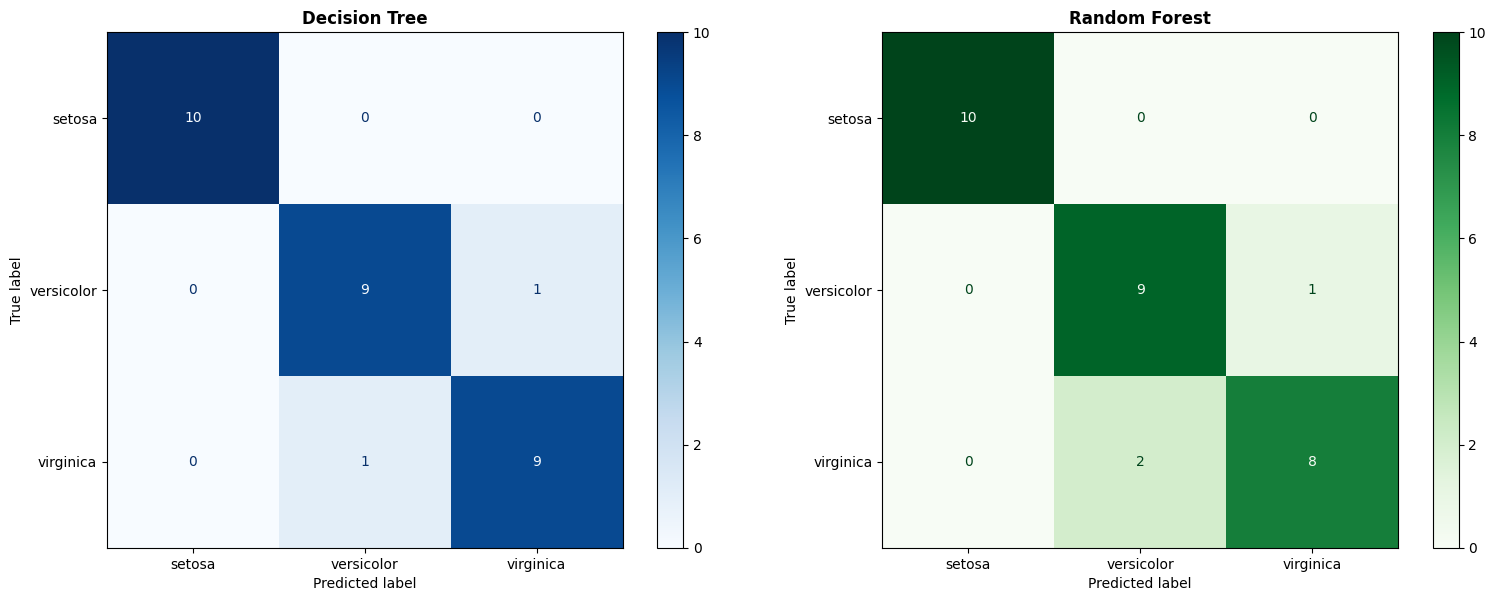


------------------------------------------------------------
АНАЛИЗ ИНТЕРПРЕТИРУЕМОСТИ
------------------------------------------------------------

Decision Tree:
  Количество узлов: 15
  Глубина: 5
  Листья: 8
  Интерпретируемость: ★★★★★ (очень высокая)
  Можно визуализировать и понять каждое решение

Random Forest:
  Количество деревьев: 100
  Средняя глубина: 4.8
  Интерпретируемость: ★★☆☆☆ (низкая)
  Сложно понять конкретные решения

ИТОГОВОЕ СРАВНЕНИЕ
             Критерий Decision Tree Random Forest
      Точность (Test)          ⭐⭐⭐⭐         ⭐⭐⭐⭐⭐
         Переобучение    ⚠ Возможно    ✓ Устойчив
   Интерпретируемость         ⭐⭐⭐⭐⭐            ⭐⭐
    Скорость обучения         ⭐⭐⭐⭐⭐           ⭐⭐⭐
Скорость предсказания         ⭐⭐⭐⭐⭐           ⭐⭐⭐

ВЫВОДЫ
✓ Decision Tree:
  - Отлично подходит когда нужна интерпретируемость
  - Быстрое обучение и предсказание
  - Возможно переобучение на сложных данных
  - Идеален для объяснения решений

✓ Random Forest:
  - Более высокая точность 

In [ ]:
# Ваш код для дополнительных заданий

print("=" * 60)
print("ДОПОЛНИТЕЛЬНЫЕ ЗАДАНИЯ")
print("=" * 60)

# ============================================================================
# 1. ОБРАБОТКА НЕСБАЛАНСИРОВАННЫХ ДАННЫХ
# ============================================================================

print("\n" + "=" * 60)
print("ЗАДАНИЕ 1: ОБРАБОТКА НЕСБАЛАНСИРОВАННЫХ ДАННЫХ")
print("=" * 60)

# Создание несбалансированного датасета
np.random.seed(42)

# Оставляем все образцы класса 0 и 1, но удаляем 80% образцов класса 2
indices_class_0 = np.where(y == 0)[0]
indices_class_1 = np.where(y == 1)[0]
indices_class_2 = np.where(y == 2)[0]

# Оставляем только 20% класса 2
n_class_2_keep = int(len(indices_class_2) * 0.2)
indices_class_2_keep = np.random.choice(indices_class_2, n_class_2_keep, replace=False)

# Объединяем индексы
imbalanced_indices = np.concatenate([indices_class_0, indices_class_1, indices_class_2_keep])
np.random.shuffle(imbalanced_indices)

X_imb = X[imbalanced_indices]
y_imb = y[imbalanced_indices]

print("\nРаспределение классов:")
print(f"Исходный датасет: {np.bincount(y)}")
print(f"Несбалансированный датасет: {np.bincount(y_imb)}")

# Разделение несбалансированного датасета
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.2, random_state=42, stratify=y_imb
)

# Базовая модель на несбалансированных данных
tree_imb_base = DecisionTreeClassifier(random_state=42)
tree_imb_base.fit(X_train_imb, y_train_imb)
score_imb_base = tree_imb_base.score(X_test_imb, y_test_imb)

print(f"\nБазовая модель (без балансировки): {score_imb_base:.4f}")
print("\nОтчет о классификации (без балансировки):")
print(classification_report(y_test_imb, tree_imb_base.predict(X_test_imb), 
                          target_names=iris.target_names))

# Техника 1: Class weights
print("\n" + "-" * 60)
print("ТЕХНИКА 1: CLASS WEIGHTS")
print("-" * 60)

tree_imb_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_imb_weighted.fit(X_train_imb, y_train_imb)
score_imb_weighted = tree_imb_weighted.score(X_test_imb, y_test_imb)

print(f"Модель с class_weight='balanced': {score_imb_weighted:.4f}")
print("\nОтчет о классификации (class weights):")
print(classification_report(y_test_imb, tree_imb_weighted.predict(X_test_imb), 
                          target_names=iris.target_names))

# Техника 2: SMOTE (Synthetic Minority Over-sampling Technique)
print("\n" + "-" * 60)
print("ТЕХНИКА 2: SMOTE")
print("-" * 60)

try:
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imb, y_train_imb)
    
    print(f"Распределение после SMOTE: {np.bincount(y_train_smote)}")
    
    tree_imb_smote = DecisionTreeClassifier(random_state=42)
    tree_imb_smote.fit(X_train_smote, y_train_smote)
    score_imb_smote = tree_imb_smote.score(X_test_imb, y_test_imb)
    
    print(f"Модель с SMOTE: {score_imb_smote:.4f}")
    print("\nОтчет о классификации (SMOTE):")
    print(classification_report(y_test_imb, tree_imb_smote.predict(X_test_imb), 
                              target_names=iris.target_names))
    
    smote_available = True
except ImportError:
    print("⚠ imbalanced-learn не установлен. Пропускаем SMOTE.")
    print("  Для установки: pip install imbalanced-learn")
    smote_available = False
    score_imb_smote = 0

# Сравнение методов
imbalance_comparison = pd.DataFrame({
    'Метод': ['Без балансировки', 'Class Weights', 'SMOTE'] if smote_available else ['Без балансировки', 'Class Weights'],
    'Точность': [score_imb_base, score_imb_weighted, score_imb_smote] if smote_available else [score_imb_base, score_imb_weighted]
})

print("\n" + "-" * 60)
print("СРАВНЕНИЕ МЕТОДОВ")
print("-" * 60)
print(imbalance_comparison.to_string(index=False))

fig = px.bar(imbalance_comparison, x='Метод', y='Точность',
             title='Сравнение методов обработки несбалансированных данных',
             text='Точность',
             color='Точность',
             color_continuous_scale='Viridis')
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis_range=[0, 1.1])
fig.show()

# ============================================================================
# 2. PRUNING (ОБРЕЗКА ДЕРЕВА)
# ============================================================================

print("\n" + "=" * 60)
print("ЗАДАНИЕ 2: PRUNING (ОБРЕЗКА ДЕРЕВА)")
print("=" * 60)

# Создаем переобученное дерево (без ограничений)
tree_overfit = DecisionTreeClassifier(random_state=42)
tree_overfit.fit(X_train, y_train)

train_score_overfit = tree_overfit.score(X_train, y_train)
test_score_overfit = tree_overfit.score(X_test, y_test)

print(f"\nПереобученное дерево (без ограничений):")
print(f"  Глубина: {tree_overfit.get_depth()}")
print(f"  Листья: {tree_overfit.get_n_leaves()}")
print(f"  Train: {train_score_overfit:.4f}")
print(f"  Test: {test_score_overfit:.4f}")
print(f"  Разница: {(train_score_overfit - test_score_overfit)*100:.2f}%")

# Cost complexity pruning (CCP)
print("\n" + "-" * 60)
print("COST COMPLEXITY PRUNING")
print("-" * 60)

# Получаем путь обрезки
path = tree_overfit.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print(f"\nКоличество значений alpha: {len(ccp_alphas)}")
print(f"Alpha от {ccp_alphas[0]:.6f} до {ccp_alphas[-1]:.6f}")

# Визуализация зависимости impurity от alpha
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
axes[0].set_xlabel('Alpha', fontsize=11)
axes[0].set_ylabel('Total Impurity', fontsize=11)
axes[0].set_title('Зависимость Total Impurity от Alpha', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Обучаем деревья с разными alpha
trees = []
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

# Визуализация точности
axes[1].plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle='steps-post')
axes[1].plot(ccp_alphas, test_scores, marker='s', label='Test', drawstyle='steps-post')
axes[1].set_xlabel('Alpha', fontsize=11)
axes[1].set_ylabel('Точность', fontsize=11)
axes[1].set_title('Зависимость точности от Alpha', fontsize=12, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Находим оптимальное alpha
best_alpha_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_idx]
best_pruned_tree = trees[best_alpha_idx]

print(f"\nОптимальное alpha: {best_alpha:.6f}")
print(f"\nОбрезанное дерево:")
print(f"  Глубина: {best_pruned_tree.get_depth()}")
print(f"  Листья: {best_pruned_tree.get_n_leaves()}")
print(f"  Train: {train_scores[best_alpha_idx]:.4f}")
print(f"  Test: {test_scores[best_alpha_idx]:.4f}")
print(f"  Разница: {(train_scores[best_alpha_idx] - test_scores[best_alpha_idx])*100:.2f}%")

# Сравнение до и после pruning
pruning_comparison = pd.DataFrame({
    'Модель': ['До обрезки', 'После обрезки'],
    'Train': [train_score_overfit, train_scores[best_alpha_idx]],
    'Test': [test_score_overfit, test_scores[best_alpha_idx]],
    'Глубина': [tree_overfit.get_depth(), best_pruned_tree.get_depth()],
    'Листья': [tree_overfit.get_n_leaves(), best_pruned_tree.get_n_leaves()]
})

print("\n" + "-" * 60)
print("СРАВНЕНИЕ ДО И ПОСЛЕ PRUNING")
print("-" * 60)
print(pruning_comparison.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

plot_tree(tree_overfit, feature_names=iris.feature_names,
          class_names=iris.target_names, filled=True, rounded=True,
          fontsize=8, ax=axes[0], max_depth=3)
axes[0].set_title('До обрезки (глубина ≤ 3 для отображения)', fontsize=12, fontweight='bold')

plot_tree(best_pruned_tree, feature_names=iris.feature_names,
          class_names=iris.target_names, filled=True, rounded=True,
          fontsize=9, ax=axes[1])
axes[1].set_title(f'После обрезки (alpha={best_alpha:.4f})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ВИЗУАЛИЗАЦИЯ РЕШЕНИЙ
# ============================================================================

print("\n" + "=" * 60)
print("ЗАДАНИЕ 3: ВИЗУАЛИЗАЦИЯ РЕШЕНИЙ")
print("=" * 60)

# Функция для отображения пути принятия решений
def get_decision_path(tree, X_sample, feature_names, class_names):
    """Получает путь принятия решения для конкретного образца"""
    decision_path = tree.decision_path(X_sample.reshape(1, -1))
    node_indices = decision_path.indices
    
    print("\nПУТЬ ПРИНЯТИЯ РЕШЕНИЯ:")
    print("-" * 60)
    
    for node_id in node_indices:
        if tree.tree_.feature[node_id] != -2:  # Не листовой узел
            feature = feature_names[tree.tree_.feature[node_id]]
            threshold = tree.tree_.threshold[node_id]
            value = X_sample[tree.tree_.feature[node_id]]
            
            if value <= threshold:
                inequality = "<="
                direction = "ВЛЕВО"
            else:
                inequality = ">"
                direction = "ВПРАВО"
            
            print(f"Узел {node_id}: {feature} = {value:.2f} {inequality} {threshold:.2f} → {direction}")
        else:
            # Листовой узел
            class_idx = np.argmax(tree.tree_.value[node_id])
            class_name = class_names[class_idx]
            probabilities = tree.tree_.value[node_id][0] / tree.tree_.value[node_id][0].sum()
            
            print(f"\nЛИСТОВОЙ УЗЕЛ {node_id}:")
            print(f"  Предсказанный класс: {class_name}")
            print(f"  Вероятности:")
            for i, cn in enumerate(class_names):
                print(f"    {cn}: {probabilities[i]:.4f}")
    
    return node_indices

# Демонстрация на нескольких образцах
print("\n" + "-" * 60)
print("ПРИМЕРЫ ПРИНЯТИЯ РЕШЕНИЙ")
print("-" * 60)

for i in range(3):
    sample_idx = i * 10
    X_sample = X_test[sample_idx]
    y_true = y_test[sample_idx]
    y_pred = final_model.predict(X_sample.reshape(1, -1))[0]
    
    print(f"\n{'=' * 60}")
    print(f"ОБРАЗЕЦ {i + 1} (индекс {sample_idx}):")
    print(f"Признаки: {X_sample}")
    print(f"Истинный класс: {iris.target_names[y_true]}")
    print(f"Предсказанный класс: {iris.target_names[y_pred]}")
    
    path = get_decision_path(final_model, X_sample, iris.feature_names, iris.target_names)

# Визуализация областей решений на плоскости
print("\n" + "-" * 60)
print("ВИЗУАЛИЗАЦИЯ ОБЛАСТЕЙ РЕШЕНИЙ")
print("-" * 60)

# Используем первые 2 признака для визуализации
feature_idx = [2, 3]  # petal length и petal width
feature_names_viz = [iris.feature_names[i] for i in feature_idx]

X_viz = X[:, feature_idx]
X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(
    X_viz, y, test_size=0.2, random_state=42
)

# Обучаем дерево на этих 2 признаках
tree_viz = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_viz.fit(X_train_viz, y_train_viz)

# Создаем сетку для визуализации
x_min, x_max = X_viz[:, 0].min() - 0.5, X_viz[:, 0].max() + 0.5
y_min, y_max = X_viz[:, 1].min() - 0.5, X_viz[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = tree_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация
plt.figure(figsize=(14, 10))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis', levels=2)
plt.contour(xx, yy, Z, colors='black', linewidths=1, alpha=0.3)

# Отображаем данные
for i, class_name in enumerate(iris.target_names):
    plt.scatter(X_viz[y == i, 0], X_viz[y == i, 1],
               label=class_name, s=100, edgecolor='black',
               cmap='viridis', alpha=0.8)

plt.xlabel(feature_names_viz[0], fontsize=12)
plt.ylabel(feature_names_viz[1], fontsize=12)
plt.title('Области решений дерева на плоскости признаков', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.colorbar(label='Класс')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Интерактивная визуализация с plotly
fig = go.Figure()

# Контуры решений
fig.add_trace(go.Contour(
    x=xx[0],
    y=yy[:, 0],
    z=Z,
    colorscale='Viridis',
    opacity=0.3,
    showscale=False,
    contours=dict(start=0, end=2, size=1)
))

# Точки данных
colors_map = {0: 'blue', 1: 'red', 2: 'green'}
for i, class_name in enumerate(iris.target_names):
    mask = y == i
    fig.add_trace(go.Scatter(
        x=X_viz[mask, 0],
        y=X_viz[mask, 1],
        mode='markers',
        name=class_name,
        marker=dict(size=10, line=dict(width=1, color='black'))
    ))

fig.update_layout(
    title='Интерактивная визуализация областей решений',
    xaxis_title=feature_names_viz[0],
    yaxis_title=feature_names_viz[1],
    height=700,
    width=900
)
fig.show()

# ============================================================================
# 4. СРАВНЕНИЕ С RANDOM FOREST
# ============================================================================

print("\n" + "=" * 60)
print("ЗАДАНИЕ 4: СРАВНЕНИЕ С RANDOM FOREST")
print("=" * 60)

# Обучение Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

print(f"\nRandom Forest (100 деревьев):")
print(f"  Train: {rf_train_score:.4f}")
print(f"  Test: {rf_test_score:.4f}")

print(f"\nDecision Tree (оптимизированное):")
print(f"  Train: {train_score_opt:.4f}")
print(f"  Test: {test_score_opt:.4f}")

print(f"\nУлучшение Random Forest: {(rf_test_score - test_score_opt)*100:.2f}%")

# Сравнение важности признаков
dt_importance = final_model.feature_importances_
rf_importance = rf_model.feature_importances_

importance_comp = pd.DataFrame({
    'Признак': iris.feature_names,
    'Decision Tree': dt_importance,
    'Random Forest': rf_importance
})

print("\n" + "-" * 60)
print("ВАЖНОСТЬ ПРИЗНАКОВ")
print("-" * 60)
print(importance_comp.to_string(index=False))

# Визуализация сравнения важности
fig = go.Figure()

fig.add_trace(go.Bar(
    name='Decision Tree',
    x=iris.feature_names,
    y=dt_importance,
    text=dt_importance.round(4),
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Random Forest',
    x=iris.feature_names,
    y=rf_importance,
    text=rf_importance.round(4),
    textposition='outside'
))

fig.update_layout(
    title='Сравнение важности признаков: Decision Tree vs Random Forest',
    xaxis_title='Признак',
    yaxis_title='Важность',
    barmode='group',
    height=500
)
fig.show()

# Детальное сравнение производительности
print("\n" + "-" * 60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ")
print("-" * 60)

# Отчеты о классификации
y_pred_dt = final_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("\nDecision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=iris.target_names))

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, target_names=iris.target_names))

# Матрицы ошибок
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=iris.target_names)
disp_dt.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Decision Tree', fontsize=12, fontweight='bold')

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=iris.target_names)
disp_rf.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Анализ интерпретируемости
print("\n" + "-" * 60)
print("АНАЛИЗ ИНТЕРПРЕТИРУЕМОСТИ")
print("-" * 60)

print(f"\nDecision Tree:")
print(f"  Количество узлов: {final_model.tree_.node_count}")
print(f"  Глубина: {final_model.get_depth()}")
print(f"  Листья: {final_model.get_n_leaves()}")
print(f"  Интерпретируемость: ★★★★★ (очень высокая)")
print(f"  Можно визуализировать и понять каждое решение")

print(f"\nRandom Forest:")
print(f"  Количество деревьев: {rf_model.n_estimators}")
print(f"  Средняя глубина: {np.mean([tree.get_depth() for tree in rf_model.estimators_]):.1f}")
print(f"  Интерпретируемость: ★★☆☆☆ (низкая)")
print(f"  Сложно понять конкретные решения")

# Финальное сравнение
final_comp = pd.DataFrame({
    'Критерий': ['Точность (Test)', 'Переобучение', 'Интерпретируемость', 
                 'Скорость обучения', 'Скорость предсказания'],
    'Decision Tree': ['⭐⭐⭐⭐', '⚠ Возможно', '⭐⭐⭐⭐⭐', '⭐⭐⭐⭐⭐', '⭐⭐⭐⭐⭐'],
    'Random Forest': ['⭐⭐⭐⭐⭐', '✓ Устойчив', '⭐⭐', '⭐⭐⭐', '⭐⭐⭐']
})

print("\n" + "=" * 60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("=" * 60)
print(final_comp.to_string(index=False))

print("\n" + "=" * 60)
print("ВЫВОДЫ")
print("=" * 60)
print("✓ Decision Tree:")
print("  - Отлично подходит когда нужна интерпретируемость")
print("  - Быстрое обучение и предсказание")
print("  - Возможно переобучение на сложных данных")
print("  - Идеален для объяснения решений")

print("\n✓ Random Forest:")
print("  - Более высокая точность за счет ансамбля")
print("  - Устойчив к переобучению")
print("  - Низкая интерпретируемость")
print("  - Подходит для production систем")

print("\n✓ Все дополнительные задания выполнены успешно!")